## Get required modules imported

In [1]:
import copy, glob
import progressbar as PGB
import numpy as NP
import numpy.ma as MA
from scipy import interpolate, stats
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
import matplotlib.ticker as PLTick
import yaml, argparse, warnings
from astropy.io import ascii
import astropy.units as U
from astropy.stats import sigma_clipped_stats, histogram
import astropy.constants as FCNST
import astropy.cosmology as cosmology
from astroutils import DSP_modules as DSP
from astroutils import constants as CNST
from astroutils import mathops as OPS
from astroutils import nonmathops as NMO
from astroutils import lookup_operations as LKP
import astroutils
import prisim
from prisim import interferometry as RI
from prisim import bispectrum_phase as BSP
from prisim import delay_spectrum as DS

from IPython.core.debugger import set_trace
%matplotlib inline

### Print AstroUtils, PRISim version

In [2]:
print('AstroUtils git # {0}\nPRISim git # {1}'.format(astroutils.__githash__, prisim.__githash__))

AstroUtils git # 1be75833b358cbc53ff9fd12ec376a5c6335463a
PRISim git # bb083bc1abd3ef44d0b18c094fedfe3dc30ed6ac


## Set up Cosmology

In [3]:
cosmoPlanck15 = cosmology.Planck15 # Planck 2015 cosmology
cosmo100 = cosmoPlanck15.clone(name='Modified Planck 2015 cosmology with h=1.0', H0=100.0) # Modified Planck 2015 cosmology with h=1.0, H= 100 km/s/Mpc

## Read YAML file containing input parameters

In [4]:
inparmsfile = '/lustre/aoc/users/nthyagar/codes/mine/python/projects/closure/multiday_EQ28_model_RA_1.6_transit_closure_PS_analysis_parms.yaml'
with open(inparmsfile, 'r') as parms_file:
    parms = yaml.safe_load(parms_file)

In [5]:
print(parms)

{'plot': {'2b': {'action': False}, '2c': {'kprll_min': 0.85, 'action': True, 'diagoffsets_b': [[[0], [1], [0]], [[0], [1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [-1, 0, 1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]], 'diagoffsets_a': [[[0], [0]], [[0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]], 'incohax_b': [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]], 'incohax_a': [[1, 3], [1, 3], [1, 3], [1, 3]]}, '

## Parse YAML file and obtain input parameters

In [6]:
projectdir = parms['dirStruct']['projectdir']
datadir = projectdir + parms['dirStruct']['datadir']
figdir = datadir + parms['dirStruct']['figdir']
modelsdir = parms['dirStruct']['modeldir']
infiles = parms['dirStruct']['infiles']
visfile = parms['dirStruct']['visfile']
visfiletype = parms['dirStruct']['visfiletype']
hdf5_infile = parms['dirStruct']['hdf5_infile']
model_hdf5files = parms['dirStruct']['model_hdf5files']
model_labels = parms['dirStruct']['model_labels']

telescope_parms = parms['telescope']
site_latitude = telescope_parms['latitude']
site_longitude = telescope_parms['longitude']

preprocessinfo = parms['preProcessing']
preprocess = preprocessinfo['action']
flagchans = preprocessinfo['flagchans']
if flagchans is not None:
    flagchans = NP.asarray(preprocessinfo['flagchans']).reshape(-1)
flagants = preprocessinfo['flagants']
if flagants is not None:
    flagants = NP.asarray(preprocessinfo['flagants']).reshape(-1)
daybinsize = preprocessinfo['daybinsize']
ndaybins = preprocessinfo['ndaybins']
lstbinsize = preprocessinfo['lstbinsize']
band_center = preprocessinfo['band_center']
freq_resolution = preprocessinfo['freq_resolution']
mdl_ndaybins = preprocessinfo['mdl_ndaybins']

dspecinfo = parms['delaySpectrum']
subbandinfo = dspecinfo['subband']
freq_window_centers = NP.asarray(subbandinfo['freq_center'])
freq_window_bw = NP.asarray(subbandinfo['bw_eff'])
freq_window_shape = subbandinfo['shape']
freq_window_fftpow = subbandinfo['fftpow']
pad = dspecinfo['pad']
apply_flags = dspecinfo['applyflags']
if apply_flags:
    applyflags_str = 'Y'
else:
    applyflags_str = 'N'

## Read and load Reference visibilities for appropriate scaling

In [7]:
bl = NP.asarray(dspecinfo['bl'])
if bl.shape[0] != 3:
    raise ValueError('Input bl must be made of three vectors forming the triad')
bltol = dspecinfo['bltol']

infile = infiles[0]
infile_no_ext = hdf5_infile.split('.hdf5')[0]

# visdata = NP.load(visfile)
if visfile is None:
    visinfo = None
else:
    if visfiletype == 'hdf5':
        visinfo = NMO.load_dict_from_hdf5(visfile+'.hdf5')
        blind, blrefind, dbl = LKP.find_1NN(visinfo['baseline']['blvect'], bl, distance_ULIM=bltol, remove_oob=True)
        if blrefind.size != 3:
            blind_missing = NP.setdiff1d(NP.arange(3), blind, assume_unique=True)
            blind_next, blrefind_next, dbl_next = LKP.find_1NN(visinfo['baseline']['blvect'], -1*bl[blind_missing,:], distance_ULIM=bltol, remove_oob=True)
            if blind_next.size + blind.size != 3:
                raise ValueError('Exactly three baselines were not found in the reference baselines')
            else:
                blind = NP.append(blind, blind_missing[blind_next])
                blrefind = NP.append(blrefind, blrefind_next)
        else:
            blind_missing = []

        vistriad = MA.array(visinfo['vis_real'][blrefind,:,:] + 1j * visinfo['vis_imag'][blrefind,:,:], mask=visinfo['mask'][blrefind,:,:])
        if len(blind_missing) > 0:
            vistriad[-blrefind_next.size:,:,:] = vistriad[-blrefind_next.size:,:,:].conj()
    else:
        visinfo = RI.InterferometerArray(None, None, None, init_file=visfile)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [8]:
print(visfile)
print(visinfo.skyvis_freq.shape)
print(visinfo.lst/15.0) # LST in hours

/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/GLEAM_all_RA_1.6_FOV30_ephemeris/RA_1.6_transit_NFbeam_120x10.7sec_1024x97.7kHz/simdata/simvis-copy
(1738, 1024, 120)
[1.61665576 1.61963612 1.62261648 1.62559684 1.6285772  1.63155756
 1.63453792 1.63751828 1.64049864 1.643479   1.64645936 1.64943972
 1.65242008 1.65540044 1.6583808  1.66136116 1.66434152 1.66732188
 1.67030224 1.6732826  1.67626296 1.67924332 1.68222368 1.68520404
 1.6881844  1.69116476 1.69414512 1.69712548 1.70010584 1.7030862
 1.70606656 1.70904692 1.71202728 1.71500764 1.717988   1.72096836
 1.72394872 1.72692908 1.72990944 1.7328898  1.73587016 1.73885052
 1.74183088 1.74481124 1.7477916  1.75077196 1.75375232 1.75673268
 1.75971304 1.7626934  1.76567376 1.76865412 1.77163448 1.77461484
 1.7775952  1.78057556 1.78355592 1.78653628 1.78951664 1.792497
 1.79547736 1.79845772 1.80143808 1.80441844 1.8073988  1.81037916
 1.81335952 1.81633988 1.81932024 1.8223006  1.82528096 1.82826

## Load NPZ file containing Closure Phases for basic information

In [9]:
tmpnpzdata = NP.load(datadir+infile)
nchan = tmpnpzdata['flags'].shape[-1]
freqs = band_center + freq_resolution * (NP.arange(nchan) - int(0.5*nchan)) 

In [10]:
# eq28yy_npzfile = '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/Binned_Data/EQ28/YY/EQ28YY.hdf5'
# eq28yy_cpObj = BSP.ClosurePhase(eq28yy_npzfile, freqs, infmt='hdf5')
# print(eq28yy_cpObj.cpinfo['raw']['lst'])

## Initialize instance of class ClosurePhase

In [11]:
cpObj = BSP.ClosurePhase(datadir+hdf5_infile, freqs, infmt='hdf5')

In [12]:
print(cpObj.cpinfo['raw']['lst'])

[[1.61665576 1.61665576 1.61665576 1.61665576]
 [1.61963612 1.61963612 1.61963612 1.61963612]
 [1.62261648 1.62261648 1.62261648 1.62261648]
 [1.62559684 1.62559684 1.62559684 1.62559684]
 [1.6285772  1.6285772  1.6285772  1.6285772 ]
 [1.63155756 1.63155756 1.63155756 1.63155756]
 [1.63453792 1.63453792 1.63453792 1.63453792]
 [1.63751828 1.63751828 1.63751828 1.63751828]
 [1.64049864 1.64049864 1.64049864 1.64049864]
 [1.643479   1.643479   1.643479   1.643479  ]
 [1.64645936 1.64645936 1.64645936 1.64645936]
 [1.64943972 1.64943972 1.64943972 1.64943972]
 [1.65242008 1.65242008 1.65242008 1.65242008]
 [1.65540044 1.65540044 1.65540044 1.65540044]
 [1.6583808  1.6583808  1.6583808  1.6583808 ]
 [1.66136116 1.66136116 1.66136116 1.66136116]
 [1.66434152 1.66434152 1.66434152 1.66434152]
 [1.66732188 1.66732188 1.66732188 1.66732188]
 [1.67030224 1.67030224 1.67030224 1.67030224]
 [1.6732826  1.6732826  1.6732826  1.6732826 ]
 [1.67626296 1.67626296 1.67626296 1.67626296]
 [1.67924332 

In [13]:
print(cpObj.cpinfo.keys())

[u'raw', 'processed', 'errinfo']


In [14]:
print(cpObj.cpinfo['raw'].keys())
print(cpObj.cpinfo['raw']['triads'].shape)
print(cpObj.cpinfo['raw']['days'].shape)
print(cpObj.cpinfo['raw']['lst-day'].shape)
print(cpObj.cpinfo['raw']['lst'].shape)
print(cpObj.cpinfo['raw']['cphase'].shape)

[u'triads', u'cphase', u'days', u'lst-day', u'lst', u'flags']
(37, 3)
(4,)
(120, 4)
(120, 4)
(120, 4, 37, 1024)


## Smooth in LST and days

In [15]:
print('day bin size = '+str(daybinsize), 'ndaybins={0:0d}'.format(ndaybins), 'LST bin size = {0:.1f}s'.format(lstbinsize))
cpObj.smooth_in_tbins(daybinsize=daybinsize, ndaybins=ndaybins, lstbinsize=lstbinsize)

('day bin size = None', 'ndaybins=2', 'LST bin size = 60.0s')


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [16]:
print(cpObj.cpinfo['processed'].keys())

['prelim', 'native']


In [17]:
print(cpObj.cpinfo['processed']['prelim'].keys())
print(cpObj.cpinfo['processed']['prelim']['cphase'].keys())
print(cpObj.cpinfo['processed']['prelim']['lstbins'].shape)
print(cpObj.cpinfo['processed']['prelim']['lstbins'])
print(cpObj.cpinfo['processed']['prelim']['daybins'].shape)
print(cpObj.cpinfo['processed']['prelim']['daybins'])
print(cpObj.cpinfo['processed']['prelim']['cphase']['median'].shape)
print(cpObj.cpinfo['processed']['prelim']['eicp']['median'].shape)

['cphase', 'wts', 'eicp', 'dlstbins', 'daybins', 'lstbins', 'diff_dbins']
['rms', 'median', 'mad', 'mean']
(22,)
[1.62498909 1.64165576 1.65832243 1.67498909 1.69165576 1.70832243
 1.72498909 1.74165576 1.75832243 1.77498909 1.79165576 1.80832243
 1.82498909 1.84165576 1.85832243 1.87498909 1.89165576 1.90832243
 1.92498909 1.94165576 1.95832243 1.97498909]
(2,)
[2458445.83629826 2458447.83629826]
(22, 2, 37, 1024)
(22, 2, 37, 1024)


## Subtract a model of Closure Phase (optional)
### Creates new keys 'submodel' and 'residual' with a key-value structure similar to 'prelim'

In [18]:
cpObj.subtract(NP.zeros(1024))
print(cpObj.cpinfo['processed'].keys())

['prelim', 'residual', 'submodel', 'native']


## Create subsample differences to keep track of noise from the noisy data

In [19]:
# ndaybins=4
print('ndaybins={0:0d}'.format(4), 'LST bin size = {0:.1f}s'.format(lstbinsize))
cpObj.subsample_differencing(daybinsize=None, ndaybins=4, lstbinsize=lstbinsize)

('ndaybins=4', 'LST bin size = 60.0s')


In [20]:
print(cpObj.cpinfo['errinfo'].keys())
print(cpObj.cpinfo['errinfo']['daybins'].shape)
print(cpObj.cpinfo['errinfo']['lstbins'].shape)
print(len(cpObj.cpinfo['errinfo']['list_of_pair_of_pairs']))
print(cpObj.cpinfo['errinfo']['list_of_pair_of_pairs'])
print(cpObj.cpinfo['errinfo']['eicp_diff'].keys())
print(cpObj.cpinfo['errinfo']['eicp_diff']['0'].keys())
print(cpObj.cpinfo['errinfo']['eicp_diff']['0']['median'].shape)
print(cpObj.cpinfo['errinfo']['eicp_diff']['1']['median'].shape)

['wts', 'eicp_diff', 'dlstbins', 'daybins', 'lstbins', 'list_of_pair_of_pairs', 'diff_dbins']
(4,)
(22,)
3
[[0, 1, 2, 3], [0, 2, 1, 3], [0, 3, 1, 2]]
['1', '0']
['median', 'mean']
(22, 3, 37, 1024)
(22, 3, 37, 1024)


## Create an instance of class ClosurePhaseDelaySpectrum

In [21]:
cpDSobj = BSP.ClosurePhaseDelaySpectrum(cpObj)

## Prepare to compute delay spectrum of the ClosurePhaseDelaySpectrum instance

In [22]:
if visinfo is not None:
    if visfiletype == 'hdf5':
        visscaleinfo = {'vis': vistriad, 'lst': visinfo['header']['LST'], 'smoothinfo': {'op_type': 'interp1d', 'interp_kind': 'linear'}}
    else:
        visscaleinfo = {'vis': visinfo, 'bltriplet': bl, 'smoothinfo': {'op_type': 'interp1d', 'interp_kind': 'linear'}}
else:
    visscaleinfo = None

In [23]:
print('freq window centers = ', freq_window_centers)
print('freq window BW eff = ', freq_window_bw)
print('freq window shape = '+freq_window_shape)
print('freq window fftpow = {0:.1f}'.format(freq_window_fftpow))
print('pad = {0:.1f}'.format(pad))

('freq window centers = ', array([1.265e+08, 1.630e+08]))
('freq window BW eff = ', array([10000000., 10000000.]))
freq window shape = bhw
freq window fftpow = 2.0
pad = 1.0


## compute delay spectrum of the ClosurePhaseDelaySpectrum instance

In [24]:
cpds = cpDSobj.FT(freq_window_bw, freq_center=freq_window_centers, shape=freq_window_shape, fftpow=freq_window_fftpow, pad=pad, datapool='prelim', visscaleinfo=visscaleinfo, method='fft', resample=True, apply_flags=apply_flags)

/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)
/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/astroutils/mathops.py:1344: RuntimeWarning: invalid value encountered in less
  mask_out = NP.logical_or(wts_interped.data < eps, NP.isnan(wts_interped.data)) # Mask small, negative, and NaN weights


	Renormalized the shaping window to unit power.
	Renormalized the shaping window to unit power.


## Load model closure phase spectra

In [25]:
model_cpObjs = []
if model_hdf5files is not None:
    for i in range(len(model_hdf5files)):
        mdl_infile_no_ext = model_hdf5files[i].split('.hdf5')[0]
        model_cpObj = BSP.ClosurePhase(modelsdir+model_hdf5files[i], freqs, infmt='hdf5')
        model_cpObj.smooth_in_tbins(daybinsize=daybinsize, ndaybins=mdl_ndaybins[i], lstbinsize=lstbinsize)
        model_cpObj.subsample_differencing(daybinsize=None, ndaybins=4, lstbinsize=lstbinsize)
        model_cpObj.subtract(NP.zeros(1024))
        model_cpObjs += [copy.deepcopy(model_cpObj)]

## Gather info on plots to be made

In [26]:
plot_info = parms['plot']
plots = [key for key in plot_info if plot_info[key]['action']]
print(plots)

['2c', '2c_err', '3', '2', '3c']


### Plot 1h: # Plot closure spectra deviations from mean/median during the averaging process and their RMS

In [26]:
if '1h' in plots:
    statistic = plot_info['1h']['statistic']
    timetriad_selection = plot_info['1h']['selection']
    cpdev = cpObj.cpinfo['processed']['prelim']['cphase'][statistic]
    if timetriad_selection is not None:
        dayind = timetriad_selection['dayind']
    else:
        dayind = 0
    for key in timetriad_selection:
        if timetriad_selection[key] is not None:
            if key == 'triads':
                triads = map(tuple, timetriad_selection[key])
            elif key == 'lstrange':
                lstrange = timetriad_selection[key]
                lstbins = cpObj.cpinfo['processed']['prelim']['lstbins']
                if lstrange is None:
                    lstinds = NP.arange(lstbins.size)
                else:
                    lstrange = NP.asarray(lstrange)
                    lstinds = NP.where(NP.logical_and(lstbins >= lstrange.min(), lstbins <= lstrange.max()))[0]
        else:
            if key == 'triads':
                triads = map(tuple, cpDSobj.cPhase.cpinfo['raw']['triads'])
            elif key == 'lstrange':
                lstbins = cpObj.cpinfo['processed']['prelim']['lstbins']
                lstinds = NP.arange(lstbins.size)
    print(cpdev.shape)
    print(lstrange)
    print(lstbins)
    print(lstinds)

In [27]:
    ncol = 3
    nrow = min(4, int(NP.ceil(1.0*lstinds.size/ncol)))
    npages = int(NP.ceil(1.0 * lstinds.size / (nrow*ncol)))
    nlst_remain = lstinds.size
    for pagei in range(npages):
        if pagei > 0:
            nlst_remain = lstinds.size - pagei * nrow * ncol
            nrow = min(4, int(NP.ceil(1.0*nlst_remain/ncol)))
        fig, axs = PLT.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(10,8))
        for i in range(nrow):
            for j in range(ncol):
                lstind = (lstinds.size - nlst_remain) + i*ncol+j
                if lstind < lstinds.size:
                    lind = lstinds[lstind]
                    for triad in triads:
                        triad_ind = triads.index(triad)
                        axs[i,j].plot(1e-6*freqs, NP.degrees(cpdev[lind,dayind,triad_ind,:]), marker='.', ms=2, ls='none')
                        axs[i,j].text(0.5, 0.97, '{0:.2f} hrs'.format(lstbins[lind]), transform=axs[i,j].transAxes, fontsize=10, weight='medium', ha='center', va='top', color='black')
                else:
                    axs[i,j].axis('off')
                axs[i,j].set_xlim(1e-6*freqs.min(), 1e-6*freqs.max())
                axs[i,j].set_ylim(0,39)

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(top=0.95)
        fig.subplots_adjust(left=0.1)
        fig.subplots_adjust(bottom=0.15)
        fig.subplots_adjust(right=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$f$ [MHz]', fontsize=12, weight='medium', labelpad=20)
        big_ax.set_ylabel(r'$\sigma_{\phi_\nabla}$ [degrees]', fontsize=12, weight='medium', labelpad=35)

        # PLT.savefig(figdir + '{0}_cp{1}_spectra_{2}_{2}_{4}_triads_day_{4}_{5:.1f}x_sparse_page_{6:03d}_of_{8:0d}.png'.format(statistic, infile_no_ext, flags_str, datastr, len(triads), dayind, sparseness, pagei+1, npages), bbox_inches=0)
        # PLT.savefig(figdir + '{0}_cp{1}_spectra_{2}_{2}_{4}_triads_day_{4}_{5:.1f}x_sparse_page_{6:03d}_of_{8:0d}.eps'.format(statistic, infile_no_ext, flags_str, datastr, len(triads), dayind, sparseness, pagei+1, npages), bbox_inches=0)

NameError: name 'lstinds' is not defined

## Plot 2: Plot closure phase delay power spectra

In [27]:
if ('2' in plots) or ('2a' in plots) or ('2b' in plots) or ('2c' in plots) or ('2d' in plots):
    dir_PS = plot_info['2']['PS_dir']
    infile_pfx_a = plot_info['2']['infile_pfx_a']
    outfile_pfx_a = plot_info['2']['outfile_pfx_a']
    infile_pfx_b = plot_info['2']['infile_pfx_b']
    outfile_pfx_b = plot_info['2']['outfile_pfx_b']
    sampling = plot_info['2']['sampling']
    statistic = plot_info['2']['statistic']
    cohax = plot_info['2']['cohax']
    incohax = plot_info['2']['incohax']
    collapseax_a = plot_info['2']['collapseax_a']
    collapseax_b = plot_info['2']['collapseax_b']
    datapool = plot_info['2']['datapool']
    pspec_unit_type = plot_info['2']['units']
    ps_errtype = plot_info['2']['errtype']
    nsigma = plot_info['2']['nsigma']
    beaminfo = plot_info['2']['beaminfo']
    xlim = plot_info['2']['xlim']
    if infile_pfx_a is not None:
        ps_infile_a = datadir + dir_PS + infile_pfx_a + '_' + infile_no_ext + '.hdf5'
        pserr_infile_a = datadir + dir_PS + infile_pfx_a + '_' + infile_no_ext + '_errinfo.hdf5'
    if outfile_pfx_a is not None:
        ps_outfile_a = datadir + dir_PS + outfile_pfx_a + '_' + infile_no_ext + '.hdf5'
        pserr_outfile_a = datadir + dir_PS + outfile_pfx_a + '_' + infile_no_ext + '_errinfo.hdf5'

    if infile_pfx_b is not None:
        ps_infile_b = datadir + dir_PS + infile_pfx_b + '_' + infile_no_ext + '.hdf5'
        pserr_infile_b = datadir + dir_PS + infile_pfx_b + '_' + infile_no_ext + '_errinfo.hdf5'
    if outfile_pfx_b is not None:
        ps_outfile_b = datadir + dir_PS + outfile_pfx_b + '_' + infile_no_ext + '.hdf5'
        pserr_outfile_b = datadir + dir_PS + outfile_pfx_b + '_' + infile_no_ext + '_errinfo.hdf5'

    timetriad_selection = plot_info['2']['selection']
    if timetriad_selection is not None:
        dayind = timetriad_selection['days']
    for key in timetriad_selection:
        if timetriad_selection[key] is not None:
            if key == 'triads':
                triads = map(tuple, timetriad_selection[key])
            elif key == 'lstrange':
                lstrange = timetriad_selection[key]
                lstbins = cpObj.cpinfo['processed']['prelim']['lstbins']
                if lstrange is None:
                    lstinds = NP.arange(lstbins.size)
                else:
                    lstrange = NP.asarray(lstrange)
                    lstinds = NP.where(NP.logical_and(lstbins >= lstrange.min(), lstbins <= lstrange.max()))[0]
                    if lstinds.size == 0:
                        raise ValueError('No data found in the specified LST range.')
        else:
            if key == 'triads':
                triads = map(tuple, cpDSobj.cPhase.cpinfo['raw']['triads'])
            elif key == 'lstrange':
                lstbins = cpObj.cpinfo['processed']['prelim']['lstbins']
                lstinds = NP.arange(lstbins.size)
    selection = {'triads': triads, 'lst': lstinds, 'days': dayind}
    autoinfo = {'axes': cohax}
    xinfo_a = {'axes': incohax, 'avgcov': False, 'collapse_axes': collapseax_a, 'dlst_range': timetriad_selection['dlst_range']}
    xinfo_b = {'axes': incohax, 'avgcov': False, 'collapse_axes': collapseax_b, 'dlst_range': timetriad_selection['dlst_range']}

    if pspec_unit_type == 'K':
        pspec_unit = 'mK2 Mpc3'
    else:
        pspec_unit = 'Jy2 Mpc'

    subselection = plot_info['2']['subselection']
#     mdl_ndaybins = plot_info['2']['modelinfo']['mdl_ndaybins']
    mdl_day = plot_info['2']['modelinfo']['mdl_day']
    mdl_cohax = plot_info['2']['modelinfo']['mdl_cohax']
    mdl_incohax = plot_info['2']['modelinfo']['mdl_incohax']
    mdl_collapseax_a = plot_info['2']['modelinfo']['mdl_collapax_a']
    mdl_collapseax_b = plot_info['2']['modelinfo']['mdl_collapax_b']
    mdl_dir_PS = plot_info['2']['modelinfo']['PS_dir']
    mdl_infile_pfx_a = plot_info['2']['modelinfo']['infile_pfx_a']
    mdl_outfile_pfx_a = plot_info['2']['modelinfo']['outfile_pfx_a']
    mdl_infile_pfx_b = plot_info['2']['modelinfo']['infile_pfx_b']
    mdl_outfile_pfx_b = plot_info['2']['modelinfo']['outfile_pfx_b']

    if model_hdf5files is not None:
        mdl_autoinfo = [{'axes': mdl_cohax[i]} for i in range(len(model_hdf5files))]
        mdl_xinfo_a = [{'axes': mdl_incohax[i], 'avgcov': False, 'collapse_axes': mdl_collapseax_a[i], 'dlst_range': timetriad_selection['dlst_range']} for i in range(len(model_hdf5files))]
        mdl_xinfo_b = [{'axes': mdl_incohax[i], 'avgcov': False, 'collapse_axes': mdl_collapseax_b[i], 'dlst_range': timetriad_selection['dlst_range']} for i in range(len(model_hdf5files))]

    if statistic is None:
        statistic = ['mean', 'median']
    else:
        statistic = [statistic]

### Read (from existing HDF5) / compute cross-PS and cross-PS-error and save (if requested) to a HDF5 file for easier reading

In [28]:
    if infile_pfx_a is not None:
        xcpdps2_a = BSP.read_CPhase_cross_power_spectrum(ps_infile_a)
        xcpdps2_a_errinfo = BSP.read_CPhase_cross_power_spectrum(pserr_infile_a)
    else:
        xcpdps2_a = cpDSobj.compute_power_spectrum(selection=selection, autoinfo=autoinfo, xinfo=xinfo_a, units=pspec_unit_type, beamparms=beaminfo)
        xcpdps2_a_errinfo = cpDSobj.compute_power_spectrum_uncertainty(selection=selection, autoinfo=autoinfo, xinfo=xinfo_a, units=pspec_unit_type, beamparms=beaminfo)
    if outfile_pfx_a is not None:
        BSP.save_CPhase_cross_power_spectrum(xcpdps2_a, ps_outfile_a)
        BSP.save_CPhase_cross_power_spectrum(xcpdps2_a_errinfo, pserr_outfile_a)

    if infile_pfx_b is not None:
        xcpdps2_b = BSP.read_CPhase_cross_power_spectrum(ps_infile_b)
        xcpdps2_b_errinfo = BSP.read_CPhase_cross_power_spectrum(pserr_infile_b)
    else:
        xcpdps2_b = cpDSobj.compute_power_spectrum(selection=selection, autoinfo=autoinfo, xinfo=xinfo_b, units=pspec_unit_type, beamparms=beaminfo)
        xcpdps2_b_errinfo = cpDSobj.compute_power_spectrum_uncertainty(selection=selection, autoinfo=autoinfo, xinfo=xinfo_b, units=pspec_unit_type, beamparms=beaminfo)
    if outfile_pfx_b is not None:
        BSP.save_CPhase_cross_power_spectrum(xcpdps2_b, ps_outfile_b)
        BSP.save_CPhase_cross_power_spectrum(xcpdps2_b_errinfo, pserr_outfile_b)

In [29]:
    nsamples_incoh = xcpdps2_a[sampling]['whole']['nsamples_incoh']
    nsamples_coh = xcpdps2_a[sampling]['whole']['nsamples_coh']

### Read/compute model cross-PS and model cross-PS errors and save (if requested) to external HDF5 file for easier reading later

In [30]:
    model_cpDSobjs = []
    cpds_models = []
    xcpdps2_a_models = []
    xcpdps2_a_errinfo_models = []
    xcpdps2_b_models = []
    xcpdps2_b_errinfo_models = []

    if model_hdf5files is not None:
        if mdl_infile_pfx_a is not None:
            if isinstance(mdl_infile_pfx_a, list):
                if (len(mdl_infile_pfx_a) > 0):
                    if not isinstance(mdl_dir_PS, list):
                        if isinstance(mdl_dir_PS, str):
                            mdl_dir_PS = [mdl_dir_PS] * len(model_hdf5files)
                        else:
                            raise TypeError('PS directory for models must be a list of strings')
                    else:
                        if len(mdl_dir_PS) != len(model_hdf5files):
                            raise ValueError('Input model PS directories must match the number of models being analyzed.')
            else:
                raise TypeError('Input model PS infile_a prefixes must be specified as a list of strings')

        if mdl_infile_pfx_b is not None:
            if isinstance(mdl_infile_pfx_b, list):
                if len(mdl_infile_pfx_b) != len(mdl_infile_pfx_b):
                    raise ValueError('Length of input model PS infile_b prefixes must match the length of input model PS infile_a prefixes')
            else:
                raise TypeError('Input model PS infile_b prefixes must be specified as a list of strings')

        progress = PGB.ProgressBar(widgets=[PGB.Percentage(), PGB.Bar(marker='-', left=' |', right='| '), PGB.Counter(), '/{0:0d} Models '.format(len(model_hdf5files)), PGB.ETA()], maxval=len(model_hdf5files)).start()

        for i in range(len(model_hdf5files)):
            mdl_infile_no_ext = model_hdf5files[i].split('.hdf5')[0]
            mdl_ps_infile_a_provided = False
            mdl_pserr_infile_a_provided = False
            mdl_ps_infile_b_provided = False
            mdl_pserr_infile_b_provided = False
            if mdl_infile_pfx_a is not None:
                if len(mdl_infile_pfx_a) > 0:
                    if mdl_infile_pfx_a[i] is not None:
                        if not isinstance(mdl_infile_pfx_a[i], str):
                            raise TypeError('Input {0}-th model cross PS file must be a string'.format(i+1))
                        else:
                            try:
                                model_xcpdps2_a = BSP.read_CPhase_cross_power_spectrum(mdl_dir_PS[i]+mdl_infile_pfx_a[i]+'_'+mdl_infile_no_ext+'.hdf5')
                            except IOError as xcption:
                                mdl_ps_infile_a_provided = False
                                warnings.warn('Provided model cross-power spectrum infile_a "{0}" could not be opened. Will proceed with computing of model cross power spectrum based on parameters specified.'.format(mdl_dir_PS[i]+mdl_infile_pfx_a[i]+'.hdf5'))
                            else:
                                mdl_ps_infile_a_provided = True
                                xcpdps2_a_models += [copy.deepcopy(model_xcpdps2_a)]

                            try:
                                model_xcpdps2_a_errinfo = BSP.read_CPhase_cross_power_spectrum(mdl_dir_PS[i]+mdl_infile_pfx_a[i]+'_'+mdl_infile_no_ext+'_errinfo.hdf5')
                            except IOError as xcption:
                                mdl_pserr_infile_a_provided = False
                                warnings.warn('Provided model cross-power spectrum infile_a "{0}" could not be opened. Will proceed with computing of model cross power spectrum based on parameters specified.'.format(mdl_dir_PS[i]+mdl_infile_pfx_a[i]+'_errinfo.hdf5'))
                            else:
                                mdl_pserr_infile_a_provided = True
                                xcpdps2_a_errinfo_models += [copy.deepcopy(model_xcpdps2_a_errinfo)]

            if mdl_infile_pfx_b is not None:
                if len(mdl_infile_pfx_b) > 0:
                    if mdl_infile_pfx_b[i] is not None:
                        if not isinstance(mdl_infile_pfx_b[i], str):
                            raise TypeError('Input {0}-th model cross PS file must be a string'.format(i+1))
                        else:
                            try:
                                model_xcpdps2_b = BSP.read_CPhase_cross_power_spectrum(mdl_dir_PS[i]+mdl_infile_pfx_b[i]+'_'+mdl_infile_no_ext+'.hdf5')
                            except IOError as xcption:
                                mdl_ps_infile_b_provided = False
                                warnings.warn('Provided model cross-power spectrum infile_b "{0}" could not be opened. Will proceed with computing of model cross power spectrum based on parameters specified.'.format(mdl_dir_PS[i]+mdl_infile_pfx_b[i]+'.hdf5'))
                            else:
                                mdl_ps_infile_b_provided = True
                                xcpdps2_b_models += [copy.deepcopy(model_xcpdps2_b)]

                            try:
                                model_xcpdps2_b_errinfo = BSP.read_CPhase_cross_power_spectrum(mdl_dir_PS[i]+mdl_infile_pfx_b[i]+'_'+mdl_infile_no_ext+'_errinfo.hdf5')
                            except IOError as xcption:
                                mdl_pserr_infile_b_provided = False
                                warnings.warn('Provided model cross-power spectrum infile_b "{0}" could not be opened. Will proceed with computing of model cross power spectrum based on parameters specified.'.format(mdl_dir_PS[i]+mdl_infile_pfx_b[i]+'_errinfo.hdf5'))
                            else:
                                mdl_pserr_infile_b_provided = True
                                xcpdps2_b_errinfo_models += [copy.deepcopy(model_xcpdps2_b_errinfo)]

            if (not mdl_ps_infile_a_provided) or (not mdl_pserr_infile_a_provided) or (not mdl_ps_infile_b_provided) or (not mdl_pserr_infile_b_provided):
#                 model_cpObj = BSP.ClosurePhase(modelsdir+model_hdf5files[i], freqs, infmt='hdf5')
#                 model_cpObj.smooth_in_tbins(daybinsize=daybinsize, ndaybins=mdl_ndaybins[i], lstbinsize=lstbinsize)
#                 model_cpObj.subsample_differencing(daybinsize=None, ndaybins=4, lstbinsize=lstbinsize)
#                 model_cpObj.subtract(NP.zeros(1024))
#                 model_cpObjs += [copy.deepcopy(model_cpObj)]
                model_cpDSobjs += [BSP.ClosurePhaseDelaySpectrum(model_cpObjs[i])]
                cpds_models += [model_cpDSobjs[i].FT(freq_window_bw, freq_center=freq_window_centers, shape=freq_window_shape, fftpow=freq_window_fftpow, pad=pad, datapool='prelim', visscaleinfo=visscaleinfo, method='fft', resample=True, apply_flags=apply_flags)]

                if not mdl_ps_infile_a_provided:
                    xcpdps2_a_models += [model_cpDSobjs[i].compute_power_spectrum(selection=selection, autoinfo=mdl_autoinfo[i], xinfo=mdl_xinfo_a[i], units=pspec_unit_type, beamparms=beaminfo)]
                if not mdl_pserr_infile_a_provided:
                    xcpdps2_a_errinfo_models += [model_cpDSobjs[i].compute_power_spectrum_uncertainty(selection=selection, autoinfo=autoinfo, xinfo=xinfo_a, units=pspec_unit_type, beamparms=beaminfo)]

                if not mdl_ps_infile_b_provided:
                    xcpdps2_b_models += [model_cpDSobjs[i].compute_power_spectrum(selection=selection, autoinfo=mdl_autoinfo[i], xinfo=mdl_xinfo_b[i], units=pspec_unit_type, beamparms=beaminfo)]
                if not mdl_pserr_infile_b_provided:
                    xcpdps2_b_errinfo_models += [model_cpDSobjs[i].compute_power_spectrum_uncertainty(selection=selection, autoinfo=autoinfo, xinfo=xinfo_b, units=pspec_unit_type, beamparms=beaminfo)]

            else:
                model_cpObjs += [None]
                model_cpDSobjs += [None]
                cpds_models += [None]

            if mdl_outfile_pfx_a is not None:
                if isinstance(mdl_outfile_pfx_a, str):
                    mdl_outfile_pfx_a = [mdl_outfile_pfx_a] * len(model_hdf5files)
                if not isinstance(mdl_outfile_pfx_a, list):
                    raise TypeError('The model cross-power spectrum outfile prefixes must be specified as a list with item for each model.')
                if len(mdl_outfile_pfx_a) != len(mdl_dir_PS):
                    raise ValueError('Invalid number of model cross-power output files specified')
                mdl_ps_outfile_a = mdl_dir_PS[i] + mdl_outfile_pfx_a[i] + '_' + mdl_infile_no_ext + '.hdf5'
                mdl_pserr_outfile_a = mdl_dir_PS[i] + mdl_outfile_pfx_a[i] + '_' + mdl_infile_no_ext + '_errinfo.hdf5'
                BSP.save_CPhase_cross_power_spectrum(xcpdps2_a_models[-1], mdl_ps_outfile_a)
                BSP.save_CPhase_cross_power_spectrum(xcpdps2_a_errinfo_models[-1], mdl_pserr_outfile_a)

            if mdl_outfile_pfx_b is not None:
                if isinstance(mdl_outfile_pfx_b, str):
                    mdl_outfile_pfx_b = [mdl_outfile_pfx_b] * len(model_hdf5files)
                if not isinstance(mdl_outfile_pfx_b, list):
                    raise TypeError('The model cross-power spectrum outfile prefixes must be specified as a list with item for each model.')
                if len(mdl_outfile_pfx_b) != len(mdl_dir_PS):
                    raise ValueError('Invalid number of model cross-power output files specified')
                mdl_ps_outfile_b = mdl_dir_PS[i] + mdl_outfile_pfx_b[i] + '_' + mdl_infile_no_ext + '.hdf5'
                mdl_pserr_outfile_b = mdl_dir_PS[i] + mdl_outfile_pfx_b[i] + '_' + mdl_infile_no_ext + '_errinfo.hdf5'
                BSP.save_CPhase_cross_power_spectrum(xcpdps2_b_models[-1], mdl_ps_outfile_b)
                BSP.save_CPhase_cross_power_spectrum(xcpdps2_b_errinfo_models[-1], mdl_pserr_outfile_b)

            progress.update(i+1)
        progress.finish()

100% |-----------------------------------------------| 2/2 Models Time: 0:00:07


### Set up plot parameters

In [31]:
    spw = subselection['spw']
    if spw is None:
        spwind = NP.arange(xcpdps2_a[sampling]['z'].size)
    else:
        spwind = NP.asarray(spw)
    lstind = NMO.find_list_in_list(xcpdps2_a[sampling][datapool[0]]['diagoffsets'][1], NP.asarray(subselection['lstdiag']))
    dayind = NP.asarray(subselection['day'])
    dayind_models = NP.asarray(mdl_day)
    triadind = NMO.find_list_in_list(xcpdps2_a[sampling][datapool[0]]['diagoffsets'][3], NP.asarray(subselection['triaddiag']))

    errshade = {}
    for errtype in ps_errtype:
        if errtype.lower() == 'ssdiff':
            errshade[errtype] = '0.8'
        elif errtype.lower() == 'psdiff':
            errshade[errtype] = '0.6'
    
    mdl_colrs = ['red', 'green', 'blue', 'cyan', 'gray', 'orange']

In [32]:
    print(dayind)
    print(lstind)

[[0 1]]
[0 1]


## Plot 2b: Plot power spectra including individual models specified in model_hdf5files. y-axis contains both negative and positive values while still employing logarithmic scale mostly, and linear scale for small values around zero.

In [33]:
    if '2b' in plots:
        for stat in statistic:
            for zind in spwind:
                for lind in lstind:
                    for di,dind in enumerate(dayind):
                        maxabsvals = []
                        minabsvals = []
                        maxvals = []
                        minvals = []
                        fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 3.6))
                        if len(datapool) == 1:
                            axs = [axs]
                        for dpoolind,dpool in enumerate(datapool):
                            for trno,trind in enumerate([triadind[0]]):
                                if model_hdf5files is not None:
                                    for mdlind, mdl in enumerate(model_labels):
                                        if dpool in xcpdps2_a_models[mdlind][sampling]:
                                            psval = (2/3.0) * xcpdps2_a_models[mdlind][sampling][dpool][stat][zind,lind,dayind_models[di][mdlind][0],dayind_models[di][mdlind][1],trind,:].to(pspec_unit).value

                                            # negind = psval.real < 0.0
                                            # posind = NP.logical_not(negind)
                                            maxabsvals += [NP.abs(psval.real).max()]
                                            minabsvals += [NP.abs(psval.real).min()]
                                            maxvals += [psval.real.max()]
                                            minvals += [psval.real.min()]
                                            axs[dpoolind].plot(xcpdps2_a_models[mdlind][sampling]['kprll'][zind,:], psval.real, ls='none', marker='.', ms=3, color=mdl_colrs[mdlind], label='{0}'.format(mdl))

                                if dpool in xcpdps2_a[sampling]:
                                    psval = (2/3.0) * xcpdps2_a[sampling][dpool][stat][zind,lind,dind[0],dind[1],trind,:].to(pspec_unit).value
                                    psrms = (2/3.0) * NP.nanstd(xcpdps2_a_errinfo[sampling]['errinfo'][stat][zind,lind,:,trind,:], axis=0).to(pspec_unit).value

                                    maxabsvals += [NP.abs(psval.real + nsigma*psrms).max()]
                                    minabsvals += [NP.abs(psval.real).min()]
                                    maxvals += [(psval.real + nsigma*psrms).max()]
                                    minvals += [(psval.real - nsigma*psrms).min()]

                                    # axs[dpoolind].plot(xcpdps2_a[sampling]['kprll'][zind,:], psval.real, ls='none', marker='.', ms=1, color='black', label='FG+N')
                                    axs[dpoolind].errorbar(xcpdps2_a[sampling]['kprll'][zind,:], psval.real, yerr=nsigma*psrms, xerr=None, ecolor='0.8', ls='none', marker='.', ms=4, color='black', label='FG+N')

                                legend = axs[dpoolind].legend(loc='center', bbox_to_anchor=(0.5,0.3), shadow=False, fontsize=8)
                                if trno == 0:
                                    axs[dpoolind].text(0.05, 0.97, 'Real', transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                    axs[dpoolind].text(0.95, 0.97, r'$z=$'+' {0:.1f}'.format(xcpdps2_a[sampling]['z'][zind]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='right', va='top', color='black')
                                    axs[dpoolind].text(0.05, 0.92, r'$\Delta$'+'LST = {0:.1f} s'.format(lind*3.6e3*xcpdps2_a['dlst'][0]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                    axs[dpoolind].text(0.05, 0.87, 'G{0[0]:0d}{0[1]:0d}'.format(dind), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')

                                axt = axs[dpoolind].twiny()
                                axt.set_xlim(1e6*xcpdps2_a[sampling]['lags'].min(), 1e6*xcpdps2_a[sampling]['lags'].max())

                            minvals = NP.asarray(minvals)
                            maxvals = NP.asarray(maxvals)
                            minabsvals = NP.asarray(minabsvals)
                            maxabsvals = NP.asarray(maxabsvals)
                            if xlim is None:
                                axs[dpoolind].set_xlim(0.99*xcpdps2_a[sampling]['kprll'][zind,:].min(), 1.01*xcpdps2_a[sampling]['kprll'][zind,:].max())
                            else:
                                axs[dpoolind].set_xlim(xlim)
                            if NP.min(minvals) < 0.0:
                                axs[dpoolind].set_ylim(1.5*NP.min(minvals), 2*NP.max(maxabsvals))
                            else:
                                axs[dpoolind].set_ylim(0.5*NP.min(minvals), 2*NP.max(maxabsvals))
                            axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
                            tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)
                            axs[dpoolind].yaxis.set_major_locator(tickloc)
                            axs[dpoolind].grid(color='0.8', which='both', linestyle=':', lw=1)

                        fig.subplots_adjust(top=0.85)
                        fig.subplots_adjust(bottom=0.16)
                        fig.subplots_adjust(left=0.22)
                        fig.subplots_adjust(right=0.98)

                        big_ax = fig.add_subplot(111)
                        big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                        # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                        big_ax.set_xticks([])
                        big_ax.set_yticks([])
                        big_ax.set_xlabel(r'$\kappa_\parallel$'+' [pseudo '+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium', labelpad=20)
                        if pspec_unit_type == 'K':
                            big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo mK$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium', labelpad=40)
                        else:
                            big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo Jy$^2h^{-1}$ Mpc]', fontsize=12, weight='medium', labelpad=40)

                        big_axt = big_ax.twiny()
                        big_axt.set_xticks([])
                        big_axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]', fontsize=12, weight='medium', labelpad=20)

                        PLT.savefig(figdir + '{0}_symlog_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_lstdiag_{5:0d}_day_{6[0]:0d}_{6[1]:0d}_triaddiags_{7:0d}_flags_{8}.pdf'.format(infile_no_ext, xcpdps2_a[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_a['dlst'][0], subselection['lstdiag'][lind], dind, xcpdps2_a[sampling][datapool[0]]['diagoffsets'][3][trind], applyflags_str), bbox_inches=0)
                        print(figdir + '{0}_symlog_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_lstdiag_{5:0d}_day_{6[0]:0d}_{6[1]:0d}_triaddiags_{7:0d}_flags_{8}.pdf'.format(infile_no_ext, xcpdps2_a[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_a['dlst'][0], subselection['lstdiag'][lind], dind, xcpdps2_a[sampling][datapool[0]]['diagoffsets'][3][trind], applyflags_str))

## Plot 2c: Plot PS after incoherent averaging over redundant triads, LST diff range, and/or other polarization.

In [34]:
    if ('2c' in plots) or ('2c_err' in plots) or ('2d' in plots):
        kprll_min_for_rms = plot_info['2c']['kprll_min']
        if kprll_min_for_rms is None:
            kprll_min_for_rms = 0.0
        avg_incohax_a = plot_info['2c']['incohax_a']
        diagoffsets_incohax_a = plot_info['2c']['diagoffsets_a']
        diagoffsets_a = []
        avg_incohax_b = plot_info['2c']['incohax_b']
        diagoffsets_incohax_b = plot_info['2c']['diagoffsets_b']
        diagoffsets_b = []
        for combi,incax_comb in enumerate(avg_incohax_a):
            diagoffsets_a += [{}]
            for incaxind,incax in enumerate(incax_comb):
                diagoffsets_a[-1][incax] = NP.asarray(diagoffsets_incohax_a[combi][incaxind])
        xcpdps2_a_avg, excpdps2_a_avg = BSP.incoherent_cross_power_spectrum_average(xcpdps2_a, excpdps=xcpdps2_a_errinfo, diagoffsets=diagoffsets_a)

        avg_xcpdps2_a_models = []
        avg_excpdps2_a_models = []

        for combi,incax_comb in enumerate(avg_incohax_b):
            diagoffsets_b += [{}]
            for incaxind,incax in enumerate(incax_comb):
                diagoffsets_b[-1][incax] = NP.asarray(diagoffsets_incohax_b[combi][incaxind])

        # xcpdps2_b_avg, excpdps2_b_avg = BSP.incoherent_cross_power_spectrum_average(xcpdps2_b, excpdps=None, diagoffsets=diagoffsets_b)
        xcpdps2_b_avg, excpdps2_b_avg = BSP.incoherent_cross_power_spectrum_average(xcpdps2_b, excpdps=xcpdps2_b_errinfo, diagoffsets=diagoffsets_b)
        avg_xcpdps2_b_models = []
        avg_excpdps2_b_models = []

        if model_hdf5files is not None:
            progress = PGB.ProgressBar(widgets=[PGB.Percentage(), PGB.Bar(marker='-', left=' |', right='| '), PGB.Counter(), '/{0:0d} Models '.format(len(model_hdf5files)), PGB.ETA()], maxval=len(model_hdf5files)).start()

            for i in range(len(model_hdf5files)):
                avg_xcpdps2_a_model, avg_excpdps2_a_model = BSP.incoherent_cross_power_spectrum_average(xcpdps2_a_models[i], excpdps=xcpdps2_a_errinfo_models[i], diagoffsets=diagoffsets_a)
                avg_xcpdps2_a_models += [copy.deepcopy(avg_xcpdps2_a_model)]
                avg_excpdps2_a_models += [copy.deepcopy(avg_excpdps2_a_model)]

                # avg_xcpdps2_b_model, avg_excpdps2_b_model = BSP.incoherent_cross_power_spectrum_average(xcpdps2_b_models[i], excpdps=None, diagoffsets=diagoffsets_b)
                avg_xcpdps2_b_model, avg_excpdps2_b_model = BSP.incoherent_cross_power_spectrum_average(xcpdps2_b_models[i], excpdps=xcpdps2_b_errinfo_models[i], diagoffsets=diagoffsets_b)
                avg_xcpdps2_b_models += [copy.deepcopy(avg_xcpdps2_b_model)]
                avg_excpdps2_b_models += [copy.deepcopy(avg_excpdps2_b_model)]

                progress.update(i+1)
            progress.finish()

100% |-----------------------------------------------| 2/2 Models Time: 0:00:06


### Save incoherently averaged power spectra for later use

In [35]:
        # Save incoherent cross power average of the main dataset and its uncertainties
    
        xps_avg_outfile_b = datadir + dir_PS + outfile_pfx_b + '_' + infile_no_ext + '_incoh_diag_avg.hdf5'
        xpserr_avg_outfile_b = datadir + dir_PS + outfile_pfx_b + '_' + infile_no_ext + '_errinfo_incoh_diag_avg.hdf5'        
        BSP.save_CPhase_cross_power_spectrum(xcpdps2_b_avg, xps_avg_outfile_b)
        BSP.save_CPhase_cross_power_spectrum(excpdps2_b_avg, xpserr_avg_outfile_b)
        print(xpserr_avg_outfile_b)

/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/PS/xCPDPS_collapse_axes_123_EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy_errinfo_incoh_diag_avg.hdf5


In [36]:
        print(infile_no_ext)

EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy


In [37]:
        print(diagoffsets_b[0])
        print(diagoffsets_b[1])
        print(diagoffsets_b[2])
        print(diagoffsets_b[3])
        print(avg_incohax_b)
        print(diagoffsets_incohax_b)
        print(len(xcpdps2_b_avg['resampled']['whole']['median']))
        print(xcpdps2_b_avg[sampling]['whole']['median'][2].shape)
        print(xcpdps2_a_avg[sampling]['whole']['median'][3].shape)

{1: array([0]), 2: array([1]), 3: array([0])}
{1: array([0]), 2: array([1]), 3: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}
{1: array([0]), 2: array([1]), 3: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}
{1: array([0]), 2: array([-1,  0,  1]), 3: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}
[[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]
[[[0], [1], [0]], [[0], [1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [-1, 0, 1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/figures/EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy_symlog_incoh_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_flags_N_comb_0.pdf
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/figures/EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy_symlog_incoh_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_flags_N_comb_1.pdf
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/figures/EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy_symlog_incoh_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_flags_N_comb_2.pdf
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/figures/EQ28XX_GLEAM_all_RA_1.6_FOV_30_ephemeris_HERA61_noisy_symlog_incoh_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_flags_N_comb_3.pdf
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/mod

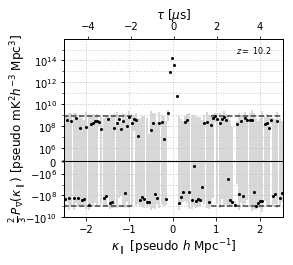

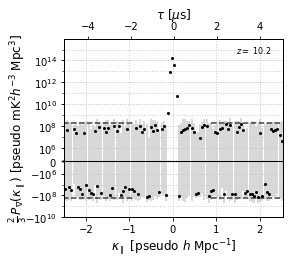

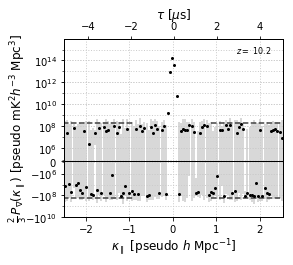

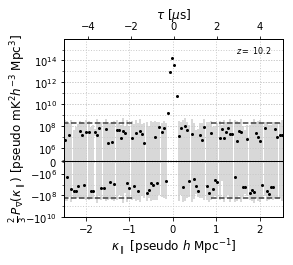

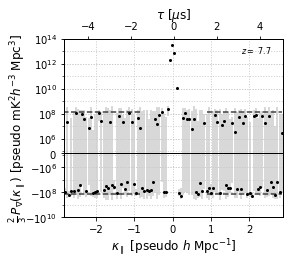

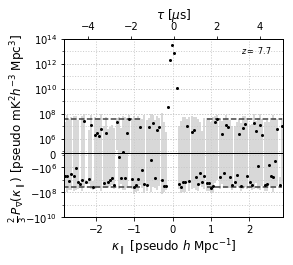

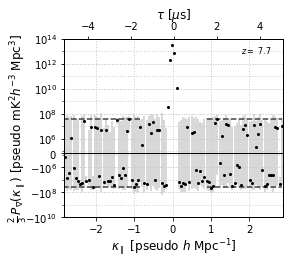

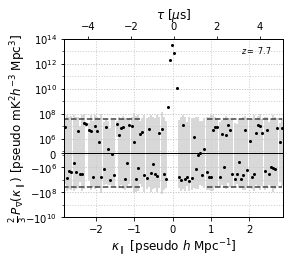

In [40]:
        if '2c' in plots:

#             ylim = {0: [-1e5, 1e9], 1: [-1e5, 1e8]} # keys are spw indices
#             linthreshy = 1e0
            ylim = {0: [-1e10, 1e16], 1: [-1e10, 1e14]} # keys are spw indices
            linthreshy = 9e5

            lstind = [0]
            triadind = [0]
            dayind = [0]
            dayind_models = NP.zeros(len(model_labels), dtype=int).reshape(1,-1)

            for stat in statistic:
                for zind in spwind:
                    kprll_ind_for_rms = NP.where(NP.abs(excpdps2_b_avg[sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
                    kprll_for_rms = excpdps2_b_avg[sampling]['kprll'][zind,kprll_ind_for_rms]
                    for lind in lstind:
                        for di,dind in enumerate(dayind):
                            for combi in range(len(diagoffsets_b)):
                                maxabsvals = []
                                minabsvals = []
                                maxvals = []
                                minvals = []
                                fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 3.6))
                                if len(datapool) == 1:
                                    axs = [axs]
                                for dpoolind,dpool in enumerate(datapool):
                                    for trno,trind in enumerate(triadind):
#                                         if model_hdf5files is not None:
#                                             for mdlind, mdl in enumerate(model_labels):
#                                                 if dpool in avg_xcpdps2_b_models[mdlind][sampling]:
#                                                     psval = (1/3.0) * avg_xcpdps2_b_models[mdlind][sampling][dpool][stat][combi][zind,lind,dayind_models[di][mdlind],trind,:].to(pspec_unit).value
#                                                     maxabsvals += [NP.abs(psval.real).max()]
#                                                     minabsvals += [NP.abs(psval.real).min()]
#                                                     maxvals += [psval.real.max()]
#                                                     minvals += [psval.real.min()]
#                                                     axs[dpoolind].plot(avg_xcpdps2_b_models[mdlind][sampling]['kprll'][zind,:], psval.real, ls='none', marker='.', ms=3, color=mdl_colrs[mdlind], label='{0}'.format(mdl))

                                        if dpool in xcpdps2_b_avg[sampling]:
                                            psval = (2/3.0) * xcpdps2_b_avg[sampling][dpool][stat][combi][zind,lind,dind,trind,:].to(pspec_unit).value
                                            ps_ssdiff = (2/3.0) * excpdps2_b_avg[sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_for_rms].to(pspec_unit).value # Single RMS across all k_prll bins
                                            psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps2_a_avg[sampling]['errinfo'][stat][combi][zind,lind,:,trind,:], axis=0).to(pspec_unit).value # RMS per k_prll bin
                                            if 2 in avg_incohax_b[combi]:
                                                ind_dayax_in_incohax = avg_incohax_b[combi].index(2)
                                                if 0 in diagoffsets_incohax_b[combi][ind_dayax_in_incohax]:
                                                    rms_inflation_factor = 2.0 * NP.sqrt(2.0)
                                                else:
                                                    rms_inflation_factor = NP.sqrt(2.0)
                                            else:
                                                rms_inflation_factor = NP.sqrt(2.0)
                                            psrms_psdiff = (2/3.0) * (xcpdps2_a_avg[sampling][dpool][stat][combi][zind,lind,1,1,trind,:] - xcpdps2_a_avg[sampling][dpool][stat][combi][zind,lind,0,0,trind,:]).to(pspec_unit).value
                                            psrms_psdiff = NP.abs(psrms_psdiff.real) / rms_inflation_factor

                                            psrms_max = NP.amax(NP.vstack((psrms_ssdiff, psrms_psdiff)), axis=0)

                                            maxabsvals += [NP.abs(psval.real + nsigma*psrms_max).max()]
                                            minabsvals += [NP.abs(psval.real).min()]
                                            maxvals += [(psval.real + nsigma*psrms_max).max()]
                                            minvals += [(psval.real - nsigma*psrms_max).min()]

                                            for errtype in ps_errtype:
                                                if errtype.lower() == 'ssdiff':                                                    
                                                    axs[dpoolind].errorbar(xcpdps2_b_avg[sampling]['kprll'][zind,:], psval.real, yerr=nsigma*psrms_ssdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black')
                                                    psmean_ssdiff_across_kbins, psmedian_ssdiff_across_kbins, psrms_ssdiff_across_kbins = sigma_clipped_stats(NP.vstack((ps_ssdiff.real, ps_ssdiff.imag)))
                                                    pos_kprll_ind_for_rms = NP.where(kprll_for_rms >= 0.0)[0]
                                                    neg_kprll_ind_for_rms = NP.where(kprll_for_rms <= 0.0)[0]
                                                    axs[dpoolind].hlines([-psrms_ssdiff_across_kbins, psrms_ssdiff_across_kbins], kprll_for_rms[pos_kprll_ind_for_rms].min(), kprll_for_rms[pos_kprll_ind_for_rms].max(), linestyles='--', lw=1.5, color='0.25')
                                                    axs[dpoolind].hlines([-psrms_ssdiff_across_kbins, psrms_ssdiff_across_kbins], kprll_for_rms[neg_kprll_ind_for_rms].min(), kprll_for_rms[neg_kprll_ind_for_rms].max(), linestyles='--', lw=1.5, color='0.25')
                                                elif errtype.lower() == 'psdiff':
                                                    axs[dpoolind].errorbar(xcpdps2_b_avg[sampling]['kprll'][zind,:], psval.real, yerr=nsigma*psrms_psdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black', label='FG+N')

#                                         legend = axs[dpoolind].legend(loc='center', bbox_to_anchor=(0.5,0.3), shadow=False, fontsize=8)
                                        if trno == 0:
                                            # axs[dpoolind].text(0.05, 0.97, 'Real', transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                            axs[dpoolind].text(0.95, 0.97, r'$z=$'+' {0:.1f}'.format(xcpdps2_b_avg[sampling]['z'][zind]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='right', va='top', color='black')
                                            # axs[dpoolind].text(0.05, 0.92, r'$\Delta$'+'LST = {0:.1f} s'.format(lind*3.6e3*xcpdps2_a_avg['dlst'][0]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                            # axs[dpoolind].text(0.05, 0.87, 'G{0[0]:0d}{0[1]:0d}'.format(dind), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')

                                        axt = axs[dpoolind].twiny()
                                        axt.set_xlim(1e6*xcpdps2_b_avg[sampling]['lags'].min(), 1e6*xcpdps2_b_avg[sampling]['lags'].max())

                                    axs[dpoolind].axhline(y=0, xmin=0, xmax=1, ls='-', lw=1, color='black')

                                    minvals = NP.asarray(minvals)
                                    maxvals = NP.asarray(maxvals)
                                    minabsvals = NP.asarray(minabsvals)
                                    maxabsvals = NP.asarray(maxabsvals)
                                    if xlim is None:
                                        axs[dpoolind].set_xlim(0.99*xcpdps2_b_avg[sampling]['kprll'][zind,:].min(), 1.01*xcpdps2_b_avg[sampling]['kprll'][zind,:].max())
                                    else:
                                        axs[dpoolind].set_xlim(xlim)
#                                     if NP.min(minvals) < 0.0:
#                                         axs[dpoolind].set_ylim(1.5*NP.min(minvals), 2*NP.max(maxabsvals))
#                                     else:
#                                         axs[dpoolind].set_ylim(0.5*NP.min(minvals), 2*NP.max(maxabsvals))
                                    axs[dpoolind].set_ylim(ylim[zind])
                                        
#                                     axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.ceil(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
#                                     tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.ceil(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)
                                    axs[dpoolind].set_yscale('symlog', linthreshy=linthreshy)
                                    tickloc = PLTick.SymmetricalLogLocator(linthresh=linthreshy, base=100.0)

                                    axs[dpoolind].yaxis.set_major_locator(tickloc)
                                    yticklocs = NP.asarray(axs[dpoolind].get_yticks())
                                    ytickspacings = NP.diff(yticklocs)
                                    tickinds_to_remove = NP.setdiff1d(NP.where(NP.abs(yticklocs)<=linthreshy)[0], NP.argmin(NP.abs(yticklocs)))
                                    if tickinds_to_remove.size > 0:
                                        new_yticklocs = yticklocs[NP.setdiff1d(NP.arange(yticklocs.size), tickinds_to_remove)]
                                        axs[dpoolind].yaxis.set_major_locator(PLTick.FixedLocator((new_yticklocs.tolist())))
                                  
                                    axs[dpoolind].grid(color='0.8', which='both', linestyle=':', lw=1)

                                fig.subplots_adjust(top=0.85)
                                fig.subplots_adjust(bottom=0.16)
                                fig.subplots_adjust(left=0.22)
                                fig.subplots_adjust(right=0.98)

                                big_ax = fig.add_subplot(111)
                                big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                                # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                                big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                                big_ax.set_xticks([])
                                big_ax.set_yticks([])
                                big_ax.set_xlabel(r'$\kappa_\parallel$'+' [pseudo '+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium', labelpad=20)
                                if pspec_unit_type == 'K':
                                    big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo mK$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium', labelpad=35)
                                else:
                                    big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo Jy$^2h^{-1}$ Mpc]', fontsize=12, weight='medium', labelpad=35)

                                big_axt = big_ax.twiny()
                                big_axt.set_xticks([])
                                big_axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]', fontsize=12, weight='medium', labelpad=20)

                                PLT.savefig(figdir + '{0}_symlog_incoh_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_b_avg[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg['dlst'][0], applyflags_str, combi), bbox_inches=0)
                                print(figdir + '{0}_symlog_incoh_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_b_avg[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg['dlst'][0], applyflags_str, combi))                                

## Plot 2c_err: PS Error analysis after incoherent averaging over redundant triads, LST diff range

median
SpW: 0, Diagcomb: 0
-------------------
Current (real): Mean = -49734378.8916,	 Median = -74178777.6097,	 RMS = 345166569.352
Other (real): Mean = -1597968788.2,	 Median = -2181348742.4,	 RMS = 4679827865.61
K-S (real): k-val = 0.754901960784,	 p-val = 3.12604644001e-52

Current (imag): Mean = -151076446.107,	 Median = -165161809.972,	 RMS = 1376083906.05
Other (imag): Mean = 101128580.743,	 Median = -15706087.549,	 RMS = 2534947462.83
K-S (imag): k-val = 0.230392156863,	 p-val = 2.98961657147e-05

Current: Mean = -76486909.3945,	 Median = -91492822.5945,	 RMS = 839909709.373
Other: Mean = -887887304.054,	 Median = -1371938388.09,	 RMS = 3755327212.36
K-S: k-val = 0.414215686275,	 p-val = 2.25571911188e-31
SpW: 0, Diagcomb: 1
-------------------
Current (real): Mean = -20866.0352744,	 Median = 3008167.17216,	 RMS = 74799398.4795
Other (real): Mean = -1684884166.68,	 Median = -2136223517.33,	 RMS = 4550926455.59
K-S (real): k-val = 0.78431372549,	 p-val = 2.39619381162e-56

Curre

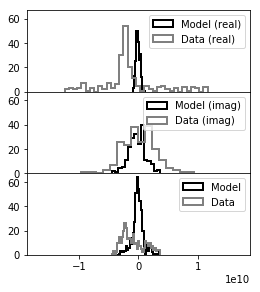

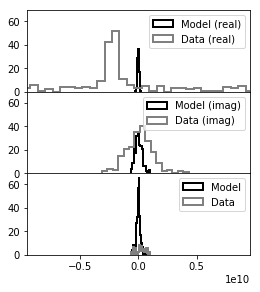

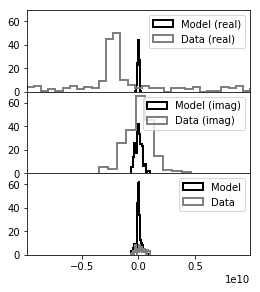

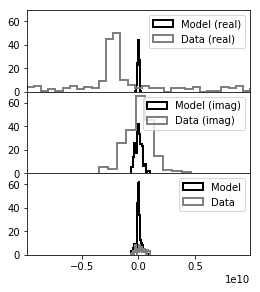

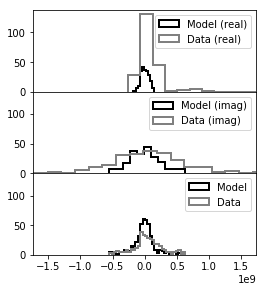

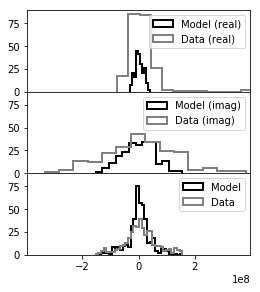

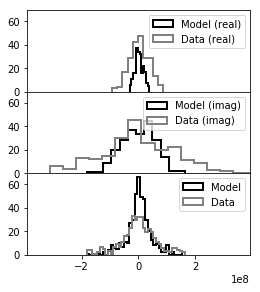

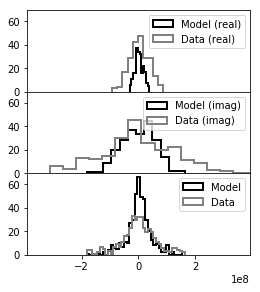

In [39]:
        if '2c_err' in plots:
            current_label = plot_info['2c_err']['current_lbl']
            other_label = plot_info['2c_err']['other_label']
            other_pserr_file = plot_info['2c_err']['other_pserr_file']
            other_excpdps2_b_avg = BSP.read_CPhase_cross_power_spectrum(other_pserr_file)
            lstind = [0]
            triadind = [0]
            dayind = [0]
            
            for stat in statistic:
                print(stat)
                print('=======================================')
                for zind in spwind:
                    kprll_ind_current_for_rms = NP.where(NP.abs(excpdps2_b_avg[sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
                    kprll_current_for_rms = excpdps2_b_avg[sampling]['kprll'][zind,kprll_ind_current_for_rms]
                    kprll_ind_other_for_rms = NP.where(NP.abs(other_excpdps2_b_avg[sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
                    kprll_other_for_rms = other_excpdps2_b_avg[sampling]['kprll'][zind,kprll_ind_other_for_rms]
                    for lind in lstind:
                        for dpoolind,dpool in enumerate(datapool):
                            for di,dind in enumerate(dayind):
                                for trno,trind in enumerate(triadind):
                                    for combi in range(len(diagoffsets_b)):
                                        ps_ssdiff_current = (2/3.0) * excpdps2_b_avg[sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_current_for_rms].to(pspec_unit).value
                                        ps_ssdiff_other = (2/3.0) * other_excpdps2_b_avg[sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_other_for_rms].to(pspec_unit).value
                                        hist_current_real, hist_current_real_bins = histogram(ps_ssdiff_current.real.ravel(), bins='knuth', density=False)
                                        hist_other_real, hist_other_real_bins = histogram(ps_ssdiff_other.real.ravel(), bins='knuth', density=False)
                                        hist_current_imag, hist_current_imag_bins = histogram(ps_ssdiff_current.imag.ravel(), bins='knuth', density=False)
                                        hist_other_imag, hist_other_imag_bins = histogram(ps_ssdiff_other.imag.ravel(), bins='knuth', density=False)
                                        hist_current, hist_current_bins = histogram(NP.vstack((ps_ssdiff_current.real,ps_ssdiff_current.imag)).ravel(), bins='knuth', density=False)
                                        hist_other, hist_other_bins = histogram(NP.vstack((ps_ssdiff_other.real,ps_ssdiff_other.imag)).ravel(), bins='knuth', density=False)

                                        current_real_mean, current_real_median, current_real_std = sigma_clipped_stats(ps_ssdiff_current.real) 
                                        current_imag_mean, current_imag_median, current_imag_std = sigma_clipped_stats(ps_ssdiff_current.imag)
                                        current_mean, current_median, current_std = sigma_clipped_stats(NP.vstack((ps_ssdiff_current.real, ps_ssdiff_current.imag)))
                                        other_real_mean, other_real_median, other_real_std = sigma_clipped_stats(ps_ssdiff_other.real) 
                                        other_imag_mean, other_imag_median, other_imag_std = sigma_clipped_stats(ps_ssdiff_other.imag)
                                        other_mean, other_median, other_std = sigma_clipped_stats(NP.vstack((ps_ssdiff_other.real, ps_ssdiff_other.imag)))

                                        real_kval, real_pval = stats.ks_2samp(ps_ssdiff_current.real.ravel(), ps_ssdiff_other.real.ravel())
                                        imag_kval, imag_pval = stats.ks_2samp(ps_ssdiff_current.imag.ravel(), ps_ssdiff_other.imag.ravel())
                                        kval, pval = stats.ks_2samp(NP.vstack((ps_ssdiff_other.real, ps_ssdiff_other.imag)).ravel(), NP.vstack((ps_ssdiff_current.real, ps_ssdiff_current.imag)).ravel())

                                        print('===================')
                                        print('SpW: {0}, Diagcomb: {1}'.format(zind, combi))
                                        print('-------------------')
                                        print('Current (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_real_mean, current_real_median, current_real_std))
                                        print('Other (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other_real_mean, other_real_median, other_real_std))
                                        print('K-S (real): k-val = {0},\t p-val = {1}'.format(real_kval, real_pval))

                                        print('\nCurrent (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_imag_mean, current_imag_median, current_imag_std))
                                        print('Other (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other_imag_mean, other_imag_median, other_imag_std))
                                        print('K-S (imag): k-val = {0},\t p-val = {1}'.format(imag_kval, imag_pval))

                                        print('\nCurrent: Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_mean, current_median, current_std))
                                        print('Other: Mean = {0},\t Median = {1},\t RMS = {2}'.format(other_mean, other_median, other_std))
                                        print('K-S: k-val = {0},\t p-val = {1}'.format(kval, pval))

                                        fig, axs = PLT.subplots(nrows=3, sharex=True, sharey=True, figsize=(4.0, 4.5))
                                        hist_current_real, hist_current_real_bins, patches = axs[0].hist(ps_ssdiff_current.real.ravel(), bins=hist_current_real_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0} (real)'.format(current_label))
                                        hist_other_real, hist_other_real_bins, patches = axs[0].hist(ps_ssdiff_other.real.ravel(), bins=hist_other_real_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0} (real)'.format(other_label))
                                        hist_current_imag, hist_current_imag_bins, patches = axs[1].hist(ps_ssdiff_current.imag.ravel(), bins=hist_current_imag_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0} (imag)'.format(current_label))
                                        hist_other_imag, hist_other_imag_bins, patches = axs[1].hist(ps_ssdiff_other.imag.ravel(), bins=hist_other_imag_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0} (imag)'.format(other_label))
                                        hist_current, hist_current_bins, patches = axs[2].hist(NP.vstack((ps_ssdiff_current.real,ps_ssdiff_current.imag)).ravel(), bins=hist_current_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0}'.format(current_label))
                                        hist_other, hist_other_bins, patches = axs[2].hist(NP.vstack((ps_ssdiff_other.real,ps_ssdiff_other.imag)).ravel(), bins=hist_current_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0}'.format(other_label))
                                        
                                        axs[0].legend(loc='upper right')
                                        axs[1].legend(loc='upper right')
                                        axs[2].legend(loc='upper right')
                                        axs[2].set_xlim(-5*other_std, 5*other_std)
                     
                                        fig.subplots_adjust(hspace=0, wspace=0)
                                        

## Plot 2d: Plot PS after incoherent averaging over k-bins, in standard PS and Delta^2 units

In [38]:
        if '2d' in plots:
            kbin_min = plot_info['2d']['kbin_min']
            kbin_max = plot_info['2d']['kbin_max']
            num_kbins = plot_info['2d']['num_kbins']
            kbintype = plot_info['2d']['kbintype']
            if (kbin_min is None) or (kbin_max is None):
                kbins = None
            else:
                if num_kbins is None:
                    raise ValueError('Input num_kbins must be set if kbin range is provided')
                if kbintype == 'linear':
                    kbins = NP.linspace(kbin_min, kbin_max, num=num_kbins, endpoint=True)
                elif kbintype == 'log':
                    if kbin_min > 0.0:
                        kbins = NP.geomspace(kbin_min, kbin_max, num=num_kbins, endpoint=True)
                    elif kbin_min == 0.0:
                        eps_k = 1e-3
                        kbins = NP.geomspace(kbin_min+eps_k, kbin_max, num=num_kbins, endpoint=True)
                    else:
                        eps_k = 1e-3
                        kbins_pos = NP.geomspace(eps_k, kbin_max, num=num_kbins, endpoint=True)
                        ind_kbin_thresh = NP.argmin(kbins_pos[kbins_pos >= NP.abs(kbin_min)])
                        kbins_neg = -1 * kbins_pos[:ind_kbin_thresh+1][::-1]
                        kbins = NP.hstack((kbins_neg, kbins_pos))
                else:
                    raise ValueError('Input kbintype must be set to "linear" or "log"')
            xcpdps2_a_avg_kbin = BSP.incoherent_kbin_averaging(xcpdps2_a_avg, kbins=kbins, kbintype=kbintype)
            excpdps2_a_avg_kbin = BSP.incoherent_kbin_averaging(excpdps2_a_avg, kbins=kbins, kbintype=kbintype)
            xcpdps2_a_avg_kbin_models = []
            excpdps2_a_avg_kbin_models = []

            xcpdps2_b_avg_kbin = BSP.incoherent_kbin_averaging(xcpdps2_b_avg, kbins=kbins, kbintype=kbintype)
            excpdps2_b_avg_kbin = BSP.incoherent_kbin_averaging(excpdps2_b_avg, kbins=kbins, kbintype=kbintype)
            xcpdps2_b_avg_kbin_models = []
            excpdps2_b_avg_kbin_models = []

            if model_hdf5files is not None:
                for i in range(len(model_hdf5files)):
                    xcpdps2_a_avg_kbin_models += [BSP.incoherent_kbin_averaging(avg_xcpdps2_a_models[i], kbins=kbins, kbintype=kbintype)]
                    excpdps2_a_avg_kbin_models += [BSP.incoherent_kbin_averaging(avg_excpdps2_a_models[i], kbins=kbins, kbintype=kbintype)]
                    xcpdps2_b_avg_kbin_models += [BSP.incoherent_kbin_averaging(avg_xcpdps2_b_models[i], kbins=kbins, kbintype=kbintype)]
                    excpdps2_b_avg_kbin_models += [BSP.incoherent_kbin_averaging(avg_excpdps2_b_models[i], kbins=kbins, kbintype=kbintype)]

In [39]:
#             print(combi)
#             print(xcpdps2_avg_kbin['resampled']['whole']['median']['PS'][0].shape)
#             print(xcpdps2_avg_kbin_models[0]['resampled']['whole']['median']['PS'][0].shape)
#             print(excpdps2_avg_kbin['resampled'].keys())
#             print(xcpdps2_avg_kbin[sampling]['kbininfo'][dpool][stat][combi][zind,lind,dind[0],dind[1],trind,:].shape)
#             print(pstype)
#             print(xcpdps2_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,dind[0],dind[1],trind,:].shape)
#             print(len(xcpdps2_avg_kbin[sampling][dpool][stat][pstype]))
#             print(psrms.shape)
#             print(dpoolind)
#             print(xcpdps2_avg_kbin[sampling]['kbininfo'][dpool][stat][combi][zind,lind,dind[0],dind[1],trind,:].shape)
#             print(len(xcpdps2_avg_kbin['oversampled']['kbininfo']['kbin_edges']))
#             print(len(excpdps2_avg_kbin['oversampled']['kbininfo']['kbin_edges']))
print(plot_info['2d'])
print(kbin_min)
print(kbins)
print(kbintype)
#             print(xcpdps2_avg_kbin[sampling]['kbininfo']['kbin_edges'][0])
#             print(xcpdps2_avg_kbin[sampling][datapool[0]]['diagoffsets'][3])

{'action': False, 'kbin_min': None, 'kbin_max': None, 'kbintype': 'linear', 'num_kbins': None}


NameError: name 'kbin_min' is not defined

NameError: name 'xcpdps2_b_avg_kbin' is not defined

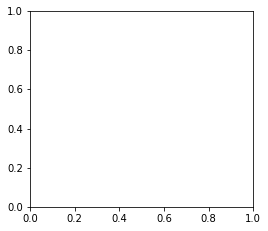

In [40]:
            lstind = [0]
            triadind = [0]
            dayind = [0]
            dayind_models = NP.zeros(len(model_labels), dtype=int).reshape(1,-1)

            for stat in statistic:
                for zind in spwind:
                    for lind in lstind:
                        for di,dind in enumerate(dayind):
                            for pstype in ['PS', 'Del2']:
                                for combi in range(len(diagoffsets_b)):
                                    maxabsvals = []
                                    minabsvals = []
                                    maxvals = []
                                    minvals = []
                                    fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 3.6))
                                    if len(datapool) == 1:
                                        axs = [axs]
                                    for dpoolind,dpool in enumerate(datapool):
                                        for trno,trind in enumerate(triadind):
#                                             if model_hdf5files is not None:
#                                                 for mdlind, mdl in enumerate(model_labels):
#                                                     if dpool in xcpdps2_b_avg_kbin_models[mdlind][sampling]:
#                                                         if pstype == 'PS':
#                                                             psval = (2/3.0) * xcpdps2_b_avg_kbin_models[mdlind][sampling][dpool][stat][pstype][combi][zind,lind,dayind_models[di][mdlind],trind,:].to(pspec_unit).value
#                                                         else:
#                                                             psval = (2/3.0) * xcpdps2_b_avg_kbin_models[mdlind][sampling][dpool][stat][pstype][combi][zind,lind,dayind_models[di][mdlind],trind,:].to('K2').value
#                                                         kval = xcpdps2_b_avg_kbin_models[mdlind][sampling]['kbininfo'][dpool][stat][combi][zind,lind,dayind_models[di][mdlind],trind,:].to('Mpc-1').value
#                                                         maxabsvals += [NP.nanmin(NP.abs(psval.real))]
#                                                         minabsvals += [NP.nanmin(NP.abs(psval.real))]
#                                                         maxvals += [NP.nanmax(psval.real)]
#                                                         minvals += [NP.nanmin(psval.real)]
#                                                         axs[dpoolind].plot(kval, psval.real, ls='none', marker='.', ms=3, color=mdl_colrs[mdlind], label='{0}'.format(mdl))

                                            if dpool in xcpdps2_b_avg_kbin[sampling]:
                                                if pstype == 'PS':
                                                    psval = (2/3.0) * xcpdps2_b_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,dind,trind,:].to(pspec_unit).value
                                                    psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps2_b_avg_kbin[sampling]['errinfo'][stat][pstype][combi][zind,lind,:,trind,:], axis=0).to(pspec_unit).value
                                                    psrms_psdiff = (2/3.0) * (xcpdps2_a_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,1,1,trind,:] - xcpdps2_a_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,0,0,trind,:]).to(pspec_unit).value
                                                else:
                                                    psval = (2/3.0) * xcpdps2_b_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,dind,trind,:].to('mK2').value
                                                    psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps2_b_avg_kbin[sampling]['errinfo'][stat][pstype][combi][zind,lind,:,trind,:], axis=0).to('mK2').value
                                                    psrms_psdiff = (2/3.0) * (xcpdps2_a_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,1,1,trind,:] - xcpdps2_a_avg_kbin[sampling][dpool][stat][pstype][combi][zind,lind,0,0,trind,:]).to('mK2').value

                                                if 2 in avg_incohax_b[combi]:
                                                    ind_dayax_in_incohax = avg_incohax_b[combi].index(2)
                                                    if 0 in diagoffsets_incohax_b[combi][ind_dayax_in_incohax]:
                                                        rms_inflation_factor = 2.0 * NP.sqrt(2.0)
                                                    else:
                                                        rms_inflation_factor = NP.sqrt(2.0)
                                                else:
                                                    rms_inflation_factor = NP.sqrt(2.0)
                                                psrms_psdiff = NP.abs(psrms_psdiff.real) / rms_inflation_factor
                                                psrms_max = NP.amax(NP.vstack((psrms_ssdiff, psrms_psdiff)), axis=0)

                                                kval = xcpdps2_b_avg_kbin[sampling]['kbininfo'][dpool][stat][combi][zind,lind,dind,trind,:].to('Mpc-1').value

                                                maxabsvals += [NP.nanmax(NP.abs(psval.real + nsigma*psrms_max.real))]
                                                minabsvals += [NP.nanmin(NP.abs(psval.real))]
                                                maxvals += [NP.nanmax(psval.real + nsigma*psrms_max.real)]
                                                minvals += [NP.nanmin(psval.real - nsigma*psrms_max.real)]
                                                
                                                for errtype in ps_errtype:
                                                    if errtype.lower() == 'ssdiff':
                                                        axs[dpoolind].errorbar(kval, psval.real, yerr=nsigma*psrms_ssdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black')
                                                    elif errtype.lower() == 'psdiff':
                                                        axs[dpoolind].errorbar(kval, psval.real, yerr=nsigma*psrms_psdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black', label='FG+N')
#                                             legend = axs[dpoolind].legend(loc='center', bbox_to_anchor=(0.5,0.3), shadow=False, fontsize=8)
                                            if trno == 0:
                                                # axs[dpoolind].text(0.05, 0.97, 'Real', transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                                axs[dpoolind].text(0.95, 0.97, r'$z=$'+' {0:.1f}'.format(xcpdps2_b_avg_kbin['resampled']['z'][zind]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='right', va='top', color='black')
                                                # axs[dpoolind].text(0.05, 0.92, r'$\Delta$'+'LST = {0:.1f} s'.format(lind*3.6e3*xcpdps2_a_avg_kbin['dlst'][0]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                                                # axs[dpoolind].text(0.05, 0.87, 'G{0[0]:0d}{0[1]:0d}'.format(dind), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')

                                        axs[dpoolind].axhline(y=0, xmin=0, xmax=1, ls='-', lw=1, color='black')

                                        minvals = NP.asarray(minvals)
                                        maxvals = NP.asarray(maxvals)
                                        minabsvals = NP.asarray(minabsvals)
                                        maxabsvals = NP.asarray(maxabsvals)
                                        axs[dpoolind].set_xlim(0.99*NP.nanmin(xcpdps2_b_avg_kbin['resampled']['kbininfo']['kbin_edges'][zind].to('Mpc-1').value), 1.01*NP.nanmax(xcpdps2_b_avg_kbin['resampled']['kbininfo']['kbin_edges'][zind].to('Mpc-1').value))
                                        if NP.min(minvals) < 0.0:
                                            axs[dpoolind].set_ylim(1.5*NP.nanmin(minvals), 2*NP.nanmax(maxabsvals))
                                        else:
                                            axs[dpoolind].set_ylim(0.5*NP.nanmin(minvals), 2*NP.nanmax(maxabsvals))
#                                         axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
#                                         tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)
                                        axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.ceil(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
                                        tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.ceil(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)

                                        axs[dpoolind].yaxis.set_major_locator(tickloc)
                                        axs[dpoolind].grid(color='0.8', which='both', linestyle=':', lw=1)

                                    fig.subplots_adjust(top=0.85)
                                    fig.subplots_adjust(bottom=0.16)
                                    fig.subplots_adjust(left=0.22)
                                    fig.subplots_adjust(right=0.98)

                                    big_ax = fig.add_subplot(111)
                                    big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                                    # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                                    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                                    big_ax.set_xticks([])
                                    big_ax.set_yticks([])
                                    big_ax.set_xlabel(r'$\kappa_\parallel$'+' [pseudo '+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium', labelpad=20)
                                    if pstype == 'PS':
                                        big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo mK$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium', labelpad=35)
                                    else:
                                        big_ax.set_ylabel(r'$\frac{2}{3}\, \Delta_\nabla^2(\kappa_\parallel)$ [pseudo mK$^2$]', fontsize=12, weight='medium', labelpad=35)

#                                     big_axt = big_ax.twiny()
#                                     big_axt.set_xticks([])
#                                     big_axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]', fontsize=12, weight='medium', labelpad=20)
                                    if pstype == 'PS':
                                        PLT.savefig(figdir + '{0}_symlog_incoh_kbin_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_a_avg_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg_kbin['dlst'][0], applyflags_str, combi), bbox_inches=0)
                                        print(figdir + '{0}_symlog_incoh_kbin_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_a_avg_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg_kbin['dlst'][0], applyflags_str, combi))
                                    else:
                                        PLT.savefig(figdir + '{0}_symlog_incoh_kbin_avg_real_cpDel2_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_a_avg_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg_kbin['dlst'][0], applyflags_str, combi), bbox_inches=0)
                                        figdir + '{0}_symlog_incoh_kbin_avg_real_cpDel2_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_flags_{5}_comb_{6:0d}.pdf'.format(infile_no_ext, xcpdps2_a_avg_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps2_b_avg_kbin['dlst'][0], applyflags_str, combi)

## Plot 3: Plot visibilities, closure spectra and standard delay power spectra from the visibilities

In [48]:
if ('3' in plots) or ('3a' in plots) or ('3b' in plots) or ('3c' in plots):

    HI_PS_dir = plot_info['3']['21cm_PS_dir']
    sim_rootdir = plot_info['3']['sim_rootdir']
    visdirs = plot_info['3']['visdirs']
    simvisdirs = [sim_rootdir+visdir for visdir in visdirs]
    simlabels = plot_info['3']['simlabels']
    visfile_prefix = plot_info['3']['visfile_prfx']

    theory_HI_PS_files = glob.glob(HI_PS_dir+'ps_*')
    z_theory_HI_PS_files = NP.asarray([fname.split('/')[-1].split('_')[3].split('z')[1] for fname in theory_HI_PS_files], dtype=NP.float)
    h_Planck15 = DS.cosmoPlanck15.h

    z_freq_window_centers = CNST.rest_freq_HI / freq_window_centers - 1
    psfile_inds = [NP.argmin(NP.abs(z_theory_HI_PS_files - z_freq_window_center)) for z_freq_window_center in z_freq_window_centers]

In [ ]:
    simvis_objs = [RI.InterferometerArray(None, None, None, init_file=simvisdir+visfile_prefix) for simvisdir in simvisdirs]

In [ ]:
    select_lst = plot_info['3']['lst']
    simlst = (simvis_objs[0].lst / 15.0) # in hours
    if select_lst is None:
        lstind = NP.asarray(NP.floor(simlst.size/2.0).astype(int)).reshape(-1)
    elif isinstance(select_lst, (int,float)):
        lstind = NP.asarray(NP.argmin(NP.abs(simlst - select_lst))).reshape(-1)
    elif isinstance(select_lst, list):
        lstind = NP.asarray([NP.argmin(NP.abs(simlst - select_lst[i])) for i in range(len(select_lst))])
    else:
        raise TypeError('Invalid format for selecting LST')

    sysT = plot_info['3']['Tsys']

## Plot 3a: Plot Visibility spectra of FG and HI amplitudes

In [ ]:
    if '3a' in plots:
        spw = plot_info['3a']['spw']
        if spw is not None:
            spwind = NP.asarray(spw).reshape(-1)

        blvects = NP.asarray(plot_info['3a']['bl'])
        bll = NP.sqrt(NP.sum(blvects**2, axis=1))
        blo = NP.degrees(NP.arctan2(blvects[:,1], blvects[:,0]))
        bltol = plot_info['3a']['bltol']
        blinds, blrefinds, dbl = LKP.find_1NN(simvis_objs[0].baselines, blvects, distance_ULIM=bltol, remove_oob=True)

        blcolrs = ['black', 'red', 'cyan']
        for lind in lstind:
            fig, axs = PLT.subplots(nrows=2, ncols=1, sharex='col', gridspec_kw={'height_ratios': [2, 1]}, figsize=(3.6, 3), constrained_layout=False)
            for simind,simlbl in enumerate(simlabels):
                if spw is not None:
                    for zind in spwind:
                        axs[simind].axvspan((freq_window_centers[zind]-0.5*freq_window_bw[zind])/1e6, (freq_window_centers[zind]+0.5*freq_window_bw[zind])/1e6, facecolor='0.8')
                for blno, blrefind in enumerate(blrefinds):
                    if simind == 0:
                        axs[simind].plot(simvis_objs[simind].channels/1e6, NP.abs(simvis_objs[simind].skyvis_freq[blrefind,:,lind]), ls='-', color=blcolrs[blno], label='{0:.1f} m, {1:.1f}'.format(bll[blno], blo[blno])+r'$^\circ$')
                        if blno == blinds.size-1:
                            axs[simind].plot(simvis_objs[simind].channels/1e6, simvis_objs[0].vis_rms_freq[blrefind,:,lind], ls='--', color='black', label='Noise RMS')
                            axs[simind].text(0.05, 0.95, 'FG', transform=axs[simind].transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                            axs[simind].set_ylabel(r'$|V|$ [Jy]', fontsize=12, weight='medium')
                            legend = axs[simind].legend(loc='upper right', shadow=False, fontsize=7)
                    else:
                        axs[simind].plot(simvis_objs[simind].channels/1e6, NP.abs(simvis_objs[0].skyvis_freq[blrefind,:,lind] + simvis_objs[simind].skyvis_freq[blrefind,:,lind]) - NP.abs(simvis_objs[0].skyvis_freq[blrefind,:,lind]), ls='-', color=blcolrs[blno], alpha=0.5)
                        if blno == blinds.size-1:
                            axs[simind].set_ylim(-5e-3, 4e-3)
                            axs[simind].text(0.95, 0.05, 'H I', transform=axs[simind].transAxes, fontsize=8, weight='medium', ha='right', va='bottom', color='black')
                            axs[simind].set_ylabel(r'$\delta |V|$ [Jy]', fontsize=12, weight='medium')
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(top=0.95)
            fig.subplots_adjust(bottom=0.15)
            fig.subplots_adjust(left=0.25)
            fig.subplots_adjust(right=0.98)

            big_ax = fig.add_subplot(111)
            big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
            big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
            big_ax.set_xticks([])
            big_ax.set_yticks([])
            big_ax.set_xlabel(r'$f$ [MHz]', fontsize=12, weight='medium', labelpad=20)
            PLT.savefig(figdir+'model_visibility_spectrum_{0:.1f}m_lst_{1:.3f}hr.pdf'.format(bll[blno], simlst[lind]), bbox_inches=0)


## Plot 3b: Plot closure phase spectrum for foregrounds and the fluctuations

In [ ]:
    if '3b' in plots:
        spw = plot_info['3b']['spw']
        if spw is not None:
            spwind = NP.asarray(spw).reshape(-1)
        for lind in lstind:
            fig, axs = PLT.subplots(nrows=2, ncols=1, sharex='col', gridspec_kw={'height_ratios': [2, 1]}, figsize=(3.6, 3), constrained_layout=False)
            for simind,simlbl in enumerate(simlabels):
                if spw is not None:
                    for zind in spwind:
                        axs[simind].axvspan((freq_window_centers[zind]-0.5*freq_window_bw[zind])/1e6, (freq_window_centers[zind]+0.5*freq_window_bw[zind])/1e6, facecolor='0.8')
                if simind == 0:
                    axs[simind].plot(model_cpObjs[simind].f/1e6, model_cpObjs[simind].cpinfo['processed']['native']['cphase'][lind,0,0,:], ls='-', color='black')
                    axs[simind].set_ylim(-NP.pi, NP.pi)
                    axs[simind].set_ylabel(r'$\phi_\nabla^\mathrm{F}(f)$ [rad]', fontsize=12, weight='medium')
                elif simind == 1:
                    axs[simind].plot(model_cpObjs[simind].f/1e6, model_cpObjs[simind].cpinfo['processed']['native']['cphase'][lind,0,0,:] - model_cpObjs[0].cpinfo['processed']['native']['cphase'][lind,0,0,:], ls='-', color='black')
                    axs[simind].set_ylim(-2e-4, 2e-4)
                    axs[simind].set_ylabel(r'$\delta\phi_\nabla^\mathrm{HI}(f)$ [rad]', fontsize=12, weight='medium')

            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(top=0.95, bottom=0.15, left=0.25, right=0.98)

            big_ax = fig.add_subplot(111)
            big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
            big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
            big_ax.set_xticks([])
            big_ax.set_yticks([])
            big_ax.set_xlabel(r'$f$ [MHz]', fontsize=12, weight='medium', labelpad=20)
            PLT.savefig(figdir+'model_cPhase_spectrum_EQ28_lst_{0:.3f}hr.pdf'.format(simlst[lind]), bbox_inches=0)                


## Plot 3c: Standard visibility-based delay power spectrum 

In [ ]:
    if '3c' in plots:
        n_days = plot_info['3c']['n_days']
        n_batches = plot_info['3c']['n_batches']
        t_field = plot_info['3c']['t_field'] * U.min
        t_int = plot_info['3c']['t_int'] * U.s
        n_pairs_of_batches = n_batches * (n_batches - 1) / 2.0 # Number of pairs of batches going into the cross-product
        n_int_per_field = t_field * 60.0 / t_int # Number of coherent integrations on a field
        npol = plot_info['3c']['npol']

        sampling = plot_info['3c']['sampling']
        spw = plot_info['3c']['spw']
        if spw is None:
            spwind = NP.arange(simDPS_objs[0].subband_delay_power_spectra['sim']['z'].size)
        else:
            spwind = NP.asarray(spw)

        eff_A = plot_info['3c']['A_eff']
        if isinstance(eff_A, (int,float)):
            eff_A = eff_A + NP.zeros_like(freq_window_centers)
        elif isinstance(eff_A, list):
            eff_A = NP.asarray(eff_A) + NP.zeros_like(freq_window_centers)
        else:
            raise TypeError('Effective area must be a scalar or list')
        eff_A = eff_A * U.m**2

        blvects = NP.asarray(plot_info['3c']['bl'])
        bll = NP.sqrt(NP.sum(blvects**2, axis=1))
        blo = NP.degrees(NP.arctan2(blvects[:,1], blvects[:,0]))
        bltol = plot_info['3c']['bltol']
        blinds, blrefinds, dbl = LKP.find_1NN(simvis_objs[0].baselines, blvects, distance_ULIM=bltol, remove_oob=True)

        bl_same_bin = plot_info['3c']['bl_same_bin']
        blvctinds = []
        blvctrefinds = []
        blhists = []
        blwts_coherent = []
        blwts_incoherent = []
        for blgrpind in range(len(bl_same_bin)):
            blvctgrp = NP.asarray(bl_same_bin[blgrpind])
            indNN_list, blind_ngbrof, blind_ngbrin = LKP.find_NN(simvis_objs[0].baselines, blvctgrp, distance_ULIM=bltol, flatten=True)
            blvctinds += [blind_ngbrin]
            blvctrefinds += [blind_ngbrof]
            blhist, blind_type, bl_binnum, ri = OPS.binned_statistic(blind_ngbrin, values=None, statistic='count', bins=range(blind_ngbrin.max()+2), range=None)
            blhists += [blhist]
            blwts_coherent += [NP.sum(blhist**2)]
            blwts_incoherent += [NP.sum(blhist)]

        if sysT is None:
            sysT = simvis_objs[0].Tsys
        elif isinstance(sysT, (int,float)):
            sysT = sysT + NP.zeros_like(simvis_objs[0].shape)
        else:
            raise TypeError('Input system temperature in invalid format')
        sysT = sysT * U.K

        freqinds = NP.asarray([NP.argmin(NP.abs(simvis_objs[0].channels - fwin)) for fwin in freq_window_centers])
        nearest_Tsys = sysT[NP.ix_(blrefinds,freqinds,lstind)]

        df = simvis_objs[0].freq_resolution * U.Hz
        sysT_per_unit_visibility = nearest_Tsys / NP.sqrt(df * t_int * n_days) # Noise RMS temperature (in K) per batch. Of this, 1/sqrt(2) each in real and imaginary parts
        sysT_per_unit_visibility_real = sysT_per_unit_visibility / NP.sqrt(2.0) # in K
        sysT_per_unit_visibility_imag = sysT_per_unit_visibility / NP.sqrt(2.0) # in K
        rms_noise_K_dspec_bin = sysT_per_unit_visibility * NP.sqrt(freq_window_bw.reshape(1,-1,1)*U.Hz / df) * df # in K.Hz, of which 1/sqrt(2) each in real and imaginary parts
        rms_noise_K_dspec_bin_real = rms_noise_K_dspec_bin / NP.sqrt(2.0) # in K.Hz
        rms_noise_K_dspec_bin_imag = rms_noise_K_dspec_bin / NP.sqrt(2.0) # in K.Hz

        # Product of two independent Gaussian random variables is a modified Bessel function of the second kind with RMS as below:

        rms_noise_K_crosssprod_bin_real = NP.sqrt(rms_noise_K_dspec_bin_real**2 * rms_noise_K_dspec_bin_real**2 + rms_noise_K_dspec_bin_imag**2 * rms_noise_K_dspec_bin_imag**2) / NP.sqrt(npol * n_pairs_of_batches * n_int_per_field) # in K^2 Hz^2, per baseline
        rms_noise_K_crosssprod_bin_imag = NP.sqrt(rms_noise_K_dspec_bin_real**2 * rms_noise_K_dspec_bin_imag**2 + rms_noise_K_dspec_bin_real**2 * rms_noise_K_dspec_bin_imag**2) / NP.sqrt(npol * n_pairs_of_batches * n_int_per_field) # in K^2 Hz^2, per baseline

        rest_freq_HI = CNST.rest_freq_HI * U.Hz
        center_redshifts = rest_freq_HI / (freq_window_centers * U.Hz) - 1
        redshifts_ulim = rest_freq_HI / ((freq_window_centers - 0.5 * freq_window_bw) * U.Hz) - 1
        redshifts_llim = rest_freq_HI / ((freq_window_centers + 0.5 * freq_window_bw) * U.Hz) - 1

        center_redshifts = center_redshifts.to_value()
        redshifts_ulim = redshifts_ulim.to_value()
        redshifts_llim = redshifts_llim.to_value()

        wl = FCNST.c / (freq_window_centers * U.Hz)
        rz = cosmo100.comoving_distance(center_redshifts)
        drz = cosmo100.comoving_distance(redshifts_ulim) - cosmo100.comoving_distance(redshifts_llim)

        conv_factor1 = (wl**2 / eff_A)
        conv_factor2 = rz**2 * drz / (freq_window_bw * U.Hz)**2
        conv_factor = conv_factor1 * conv_factor2

        noise_xpspec_rms_real = rms_noise_K_crosssprod_bin_real * conv_factor.reshape(1,-1,1)

        noise_xpspec_rms_real_blgroups = []
        for blgrpind in range(len(bl_same_bin)):
            noise_xpspec_rms_real_blgroups += [{'coh_bl': noise_xpspec_rms_real[blgrpind].to('K2 Mpc3') / NP.sqrt(blwts_coherent[blgrpind]), 'incoh_bl': noise_xpspec_rms_real[blgrpind].to('K2 Mpc3') / NP.sqrt(blwts_incoherent[blgrpind])}]


### Compute visibility-based Delay Power Spectra

In [ ]:
    if '3c' in plots:
        simDS_objs = [DS.DelaySpectrum(interferometer_array=simvis_obj) for simvis_obj in simvis_objs]

        simDPS_objs = []
        for simind,simlbl in enumerate(simlabels):
            dspec = simDS_objs[simind].delay_transform(action='store')
            subband_dspec = simDS_objs[simind].subband_delay_transform({key: freq_window_bw for key in ['cc', 'sim']}, freq_center={key: freq_window_centers for key in ['cc', 'sim']}, shape={key: freq_window_shape for key in ['cc', 'sim']}, fftpow={key: freq_window_fftpow for key in ['cc', 'sim']}, pad={key: pad for key in ['cc', 'sim']}, bpcorrect=False, action='return_resampled')
        simDPS_objs = []
        for simind,simlbl in enumerate(simlabels):
            simDPS_objs += [DS.DelayPowerSpectrum(simDS_objs[simind])]
            simDPS_objs[simind].compute_power_spectrum()        

In [ ]:
    if '3c' in plots:
        colrs_sim = ['black', 'black']
        colrs_ref = ['gray', 'gray']
        # colrs_sim = ['red', 'blue']
        # colrs_ref = ['orange', 'cyan']
        lstyles = [':', '-']
        for blno, blrefind in enumerate(blrefinds):
            for lstno,lind in enumerate(lstind):
                for zind in spwind:
                    pstable = ascii.read(theory_HI_PS_files[psfile_inds[zind]])
                    k = pstable['col1'] # in 1/Mpc
                    delta2 = 1e-6 * pstable['col2'] # in K^2
                    pk = 2 * NP.pi**2 / k**3 * delta2 # in K^2 Mpc^3
                    k_h = k / h_Planck15 # in h/Mpc
                    pk_h = pk * h_Planck15**3 # in K^2 (Mpc/h)^3

                    kprll_sim = simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['kprll'][zind,:]
                    kperp_sim = simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['kperp'][zind,blrefind]
                    k_sim = NP.sqrt(kperp_sim**2 + kprll_sim**2)

                    log10_ps_interped = OPS.interpolate_array(NP.log10(pk_h), NP.log10(k_h), NP.log10(k_sim), axis=-1, kind='linear')
                    ps_interped = 10**log10_ps_interped

                    fig = PLT.figure(figsize=(4.0, 3.6))
                    ax = fig.add_subplot(111)

                    for simind,simlbl in enumerate(simlabels):
                        if simind == 0:
                            ax.plot(simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['kprll'][zind,:], simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['skyvis_lag'][blrefind,zind,:,lind], ls=lstyles[simind], color=colrs_sim[zind], label=r'$P_\mathrm{F}$'+' ({0:.1f} MHz)'.format(freq_window_centers[zind]/1e6))
                        else:
                            ax.plot(simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['kprll'][zind,:], simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['skyvis_lag'][blrefind,zind,:,lind], ls=lstyles[simind], color=colrs_sim[zind], label=r'$P_\mathrm{HI}$'+' (sim), '+r'$z=$'+'{0:.1f}'.format(simDPS_objs[simind].subband_delay_power_spectra['sim']['z'][zind]))
                            ax.plot(simDPS_objs[simind].subband_delay_power_spectra_resampled['sim']['kprll'][zind,:], ps_interped, ls='-', color=colrs_ref[zind], label=r'$P_\mathrm{HI}$'+' (ref), '+r'$z=$'+'{0:.1f}'.format(simDPS_objs[simind].subband_delay_power_spectra['sim']['z'][zind]))
                    ax.axhline(y=noise_xpspec_rms_real_blgroups[blno]['coh_bl'][zind,lstno].to('K2 Mpc3').value, ls='--', color='gray', label=r'$P_\mathrm{N}$'+' (red.)')
                    ax.axhline(y=noise_xpspec_rms_real_blgroups[blno]['incoh_bl'][zind,lstno].to('K2 Mpc3').value, ls='--', color='black', label=r'$P_\mathrm{N}$'+' (non-red.)')
                    ax.set_yscale('log')
                    ax.legend(loc='upper right', shadow=False, fontsize=7.5)
                    ax.text(0.1, 0.9, '{0:.1f} m'.format(bll[blno]), transform=ax.transAxes, fontsize=8, weight='medium', ha='left', va='top', color='black')
                    ax.set_xlabel(r'$k_\parallel$ [$h$ Mpc$^{-1}$]')
                    ax.set_ylabel(r'$P_b(k_\parallel)$ [K$^2$ $h^{-3}$ Mpc$^3$]')
                    axt = ax.twiny()
                    axt.set_xlim(1e6*simDS_objs[simind].subband_delay_spectra_resampled['sim']['lags'].min(), 1e6*simDS_objs[simind].subband_delay_spectra_resampled['sim']['lags'].max())
                    axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]')
                    fig.subplots_adjust(bottom=0.15, left=0.18, right=0.98)

                    PLT.savefig(figdir+'delay_PS_{0:.1f}m_z_{1:.1f}_lst_{2:.3f}hr.pdf'.format(bll[blno], simDPS_objs[simind].subband_delay_power_spectra['sim']['z'][zind], simlst[lind]), bbox_inches=0)